# Time Series classification of Aerodynamics
The boundary layer on an airfoil can be in two states, Laminar or Turbulent. Visually this switch is quite easy to see, for the aerodynamics muggles, the turbulent boundary layer state with show up on the time series data from the microphone as very turbulent(or volatile if you are from the finance world). 
Other ways to solve this problem include
- Traditional signal processing tricks that can extract such a change over of course. 
- Bayesian switch point analysis with a flexible number of switch points would also work. 
- The auto-regressive type models<br>
But I wanted to try my hand at getting a time series model in torch working, so here we are. 

Principles learnt:
- Training data has to be very good
- write test train data loading as a loop less code = less bugs. 
- Display metrics for all batches in validation set. single batches don't converge enough to give good results. Not a corner worth cutting



In [1]:
import torch 
import pickle
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.utils.data
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from matplotlib import animation, rc
rc('animation', html='jshtml')
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set up Model
One layer LSTM to multi layer fully conencted.
Sigmoid on the out layer as it is a classification problem. 
More layers can be enabled but 91% Validation error is possible with our the second lstm and extra fc layers. 

In [2]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        
        self.Sig = nn.Sigmoid()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        #input.view(self.input_dim, self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(input.view(-1,len(input),6))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.Sig(self.linear(lstm_out[-1].view(len(input), -1)))
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)


# Read in data
The features of the time series have been pre-processed to include the time series itself and the first 5 mel-spectrum coefficients. 
!!! Need to double check for data leakage in the mel-spectrum coefficients 

In [7]:
def LoadData(): #just doing it as a function to clean up whats in scope/ 
    df = pd.read_pickle("Reduced.pkl")
    Split = 0.8
    SplitInd = int(Split * len(df))
    LabelList = ['ts',*range(5)]
    Input = torch.tensor(df[LabelList].values)
    Output = torch.tensor(df['Labels'].values)

    #load second file hacky way for now. Only two files needed for training set.  
    df3 = pd.read_pickle("Reduced3.pkl")

    Input3 = torch.tensor(df3[LabelList].values)
    Output3 = torch.tensor(df3['Labels'].values)

    df4 = pd.read_pickle("Sensor0-Copy1")
    df4.Labels = 1

    Input4 = torch.tensor(df4[LabelList].values)
    Output4 = torch.tensor(df4['Labels'].values)


    #Valid trainSplit
    InpTrain4, InpValid4 = Input4[:SplitInd], Input4[SplitInd:]
    OutTrain4, OutValid4 = Output4[:SplitInd], Output4[SplitInd:]


    #Valid trainSplit
    InpTrain, InpValid = Input[:SplitInd], Input[SplitInd:]
    OutTrain, OutValid = Output[:SplitInd], Output[SplitInd:]

    #Valid trainSplit
    InpTrain3, InpValid3 = Input3[:SplitInd], Input3[SplitInd:]
    OutTrain3, OutValid3 = Output3[:SplitInd], Output3[SplitInd:]

    #Concat two files. 
    InputTrain = torch.cat((InpTrain,InpTrain3,InpTrain4),0)
    InputValid = torch.cat((InpValid,InpValid3,InpValid4),0)
    OutputTrain = torch.cat((OutTrain,OutTrain3,OutTrain4),0)
    OutputValid = torch.cat((OutValid,OutValid3,OutValid4),0)

    #Train scaler on training data only. No peeking now!! 
    InpScaler = StandardScaler()
    InpScaler.fit(InputTrain)



    InputTrain = torch.tensor(InpScaler.transform(InputTrain))
    InputValid = torch.tensor(InpScaler.transform(InputValid))

    BatchSize = 200000
    #Into DataLoaders
    # Large Batch size seems to perform better. 
    TrainDataSet = torch.utils.data.TensorDataset(InputTrain, OutputTrain)
    Train = torch.utils.data.DataLoader(TrainDataSet,batch_size = BatchSize,num_workers = 1)

    ValidDataSet = torch.utils.data.TensorDataset(InputValid, OutputValid)
    Valid = torch.utils.data.DataLoader(TrainDataSet,batch_size = BatchSize,num_workers = 1)
    LenTrain = len(InpTrain)
    LenValid = len(InpValid)
    return Train, Valid, BatchSize

In [8]:
Train, Valid, BatchSize = LoadData()

In [26]:
for inp, target in Valid:
    print(target)
    

tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([0, 0, 0,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([1, 1, 1,  ..., 1, 1, 1])


In [4]:
with open('scaler.pickle', 'wb') as file:
    pickle.dump(InpScaler,file)

# Initiate with Simple paralell architecture 

In [26]:
model = Classifier(6, 6, batch_size=BatchSize, output_dim=1, num_layers=8)
model.cuda()

Classifier(
  (lstm): LSTM(6, 6, num_layers=8)
  (linear): Linear(in_features=6, out_features=1, bias=True)
  (Sig): Sigmoid()
)

# Simple SGD optimizer
Achieved 91% without momentum, Cosine Annealing appears effective from training. 
Have to implement a LR finder to better set. Works for now, probably go achieve much faster training

In [27]:
lr = 1e-1
#optimizer = torch.optim.SGD(model.parameters(),lr,momentum = 0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,1,0.1*lr)

epoch0
train loss: 1.5535792044829577e-05
valid loss: 1.3510165445040911e-05
accuracy: 69.66785185185185 %
saved


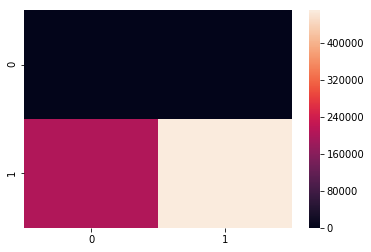

Learning Rate:[0.010000000000000002]
epoch1
train loss: 1.3439102076517884e-05
valid loss: 1.3388876141107175e-05
accuracy: 69.66785185185185 %


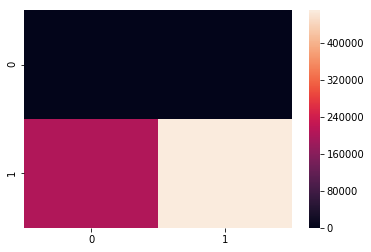

Learning Rate:[0.1]
epoch2
train loss: 1.3472428690874949e-05
valid loss: 1.339905611530412e-05
accuracy: 69.66785185185185 %


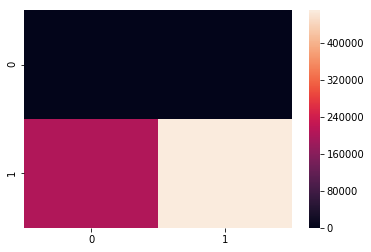

Learning Rate:[0.010000000000000002]
epoch3
train loss: 1.4607785487896763e-05
valid loss: 1.4017688044987153e-05
accuracy: 69.66785185185185 %


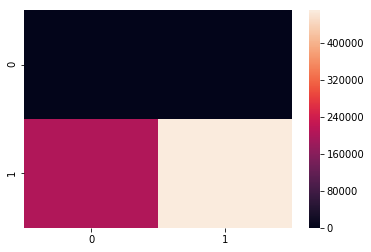

Learning Rate:[0.1]
epoch4
train loss: 1.4103557987255044e-05
valid loss: 1.407133458997123e-05
accuracy: 69.66785185185185 %


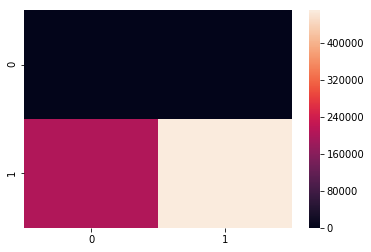

Learning Rate:[0.010000000000000002]
epoch5
train loss: 1.4480712707154453e-05
valid loss: 1.4209068467607722e-05
accuracy: 69.66785185185185 %


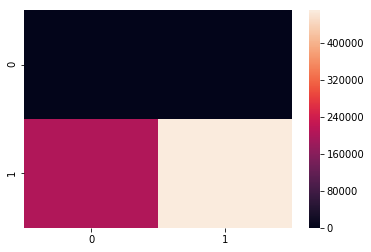

Learning Rate:[0.1]
epoch6
train loss: 1.4212506357580423e-05
valid loss: 1.4189299690769985e-05
accuracy: 69.66785185185185 %


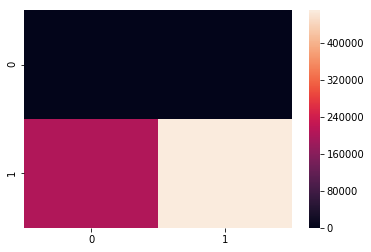

Learning Rate:[0.010000000000000002]
epoch7
train loss: 1.4039146662980784e-05
valid loss: 1.386760595778469e-05
accuracy: 69.66785185185185 %


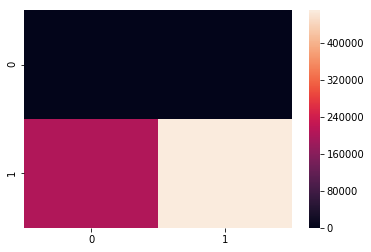

Learning Rate:[0.1]
epoch8
train loss: 1.3858283637091517e-05
valid loss: 1.3844359273207374e-05
accuracy: 69.66785185185185 %


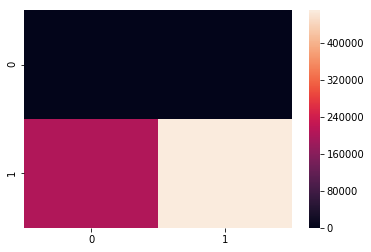

Learning Rate:[0.010000000000000002]
epoch9
train loss: 1.3853121345164254e-05
valid loss: 1.370936388411792e-05
accuracy: 69.66785185185185 %


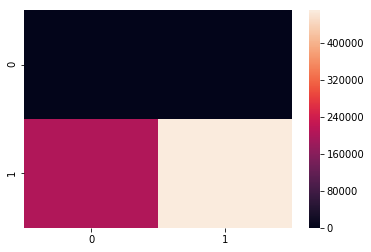

Learning Rate:[0.1]
epoch10
train loss: 1.372386577713769e-05
valid loss: 1.3707153811992612e-05
accuracy: 69.66785185185185 %


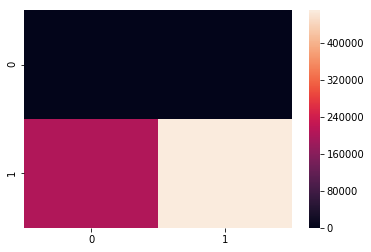

Learning Rate:[0.010000000000000002]
epoch11
train loss: 1.3967710401630029e-05
valid loss: 1.3761824448010884e-05
accuracy: 69.66785185185185 %


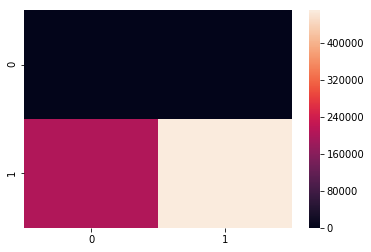

Learning Rate:[0.1]
epoch12
train loss: 1.3790317098028027e-05
valid loss: 1.3769571523880586e-05
accuracy: 69.66785185185185 %


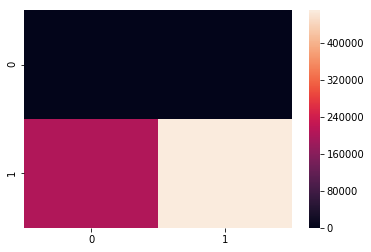

Learning Rate:[0.010000000000000002]
epoch13
train loss: 1.4069309145270381e-05
valid loss: 1.3851571566192433e-05
accuracy: 69.66785185185185 %


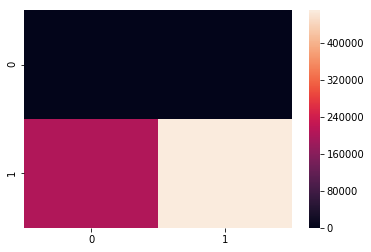

Learning Rate:[0.1]
epoch14
train loss: 1.387587508361321e-05
valid loss: 1.3855724319000728e-05
accuracy: 69.66785185185185 %


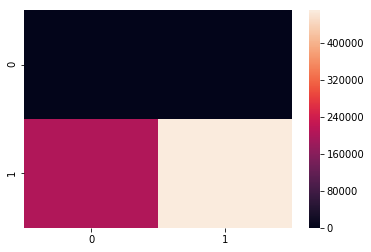

Learning Rate:[0.010000000000000002]
epoch15
train loss: 1.4063298294786364e-05
valid loss: 1.3862249033991247e-05
accuracy: 69.66785185185185 %


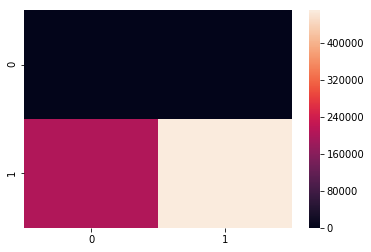

Learning Rate:[0.1]
epoch16
train loss: 1.3878550817025825e-05
valid loss: 1.3859807950211689e-05
accuracy: 69.66785185185185 %


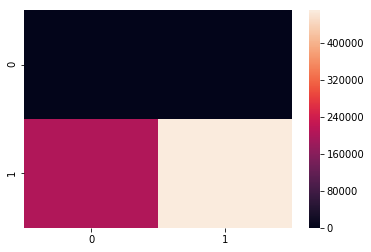

Learning Rate:[0.010000000000000002]
epoch17
train loss: 1.4011881830811035e-05
valid loss: 1.3821998436469585e-05
accuracy: 69.66785185185185 %


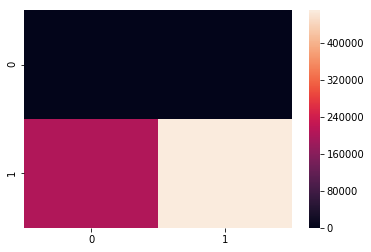

Learning Rate:[0.1]
epoch18
train loss: 1.3836654034093954e-05
valid loss: 1.3818238585372455e-05
accuracy: 69.66785185185185 %


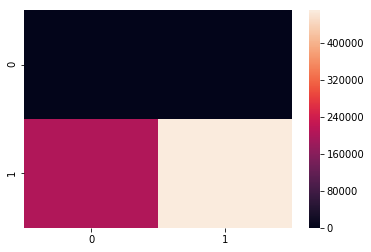

Learning Rate:[0.010000000000000002]
epoch19
train loss: 1.3981364645587746e-05
valid loss: 1.3788608157483395e-05
accuracy: 69.66785185185185 %


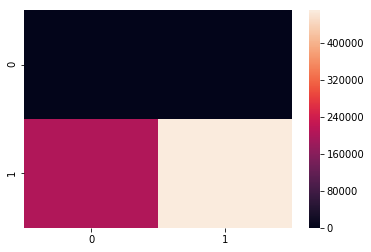

Learning Rate:[0.1]
epoch20
train loss: 1.3803612091578543e-05
valid loss: 1.3778271750197746e-05
accuracy: 69.66785185185185 %


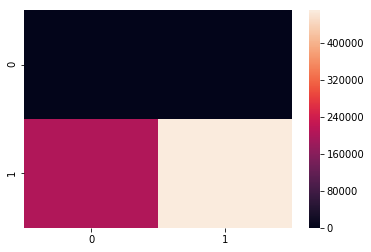

Learning Rate:[0.010000000000000002]
epoch21
train loss: 1.3951668734080158e-05
valid loss: 1.3586110981123056e-05
accuracy: 69.66785185185185 %


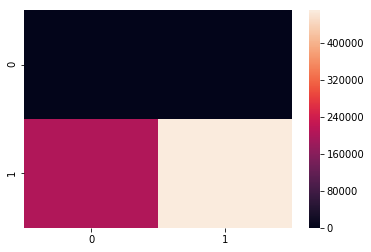

Learning Rate:[0.1]
epoch22
train loss: 1.3582965038949624e-05
valid loss: 1.3518563719117083e-05
accuracy: 69.66785185185185 %


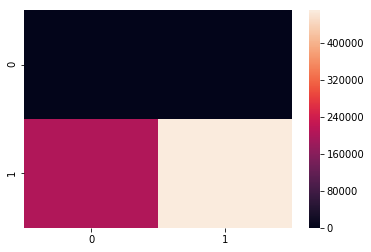

Learning Rate:[0.010000000000000002]
epoch23
train loss: 1.3203305570641533e-05
valid loss: 1.1585711945372168e-05
accuracy: 69.66785185185185 %


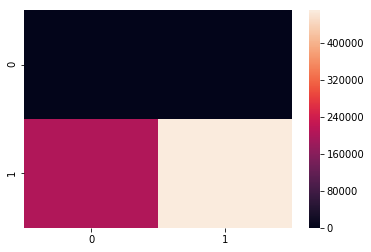

Learning Rate:[0.1]
epoch24
train loss: 1.1453619663370773e-05
valid loss: 1.117113515647361e-05
accuracy: 69.66785185185185 %


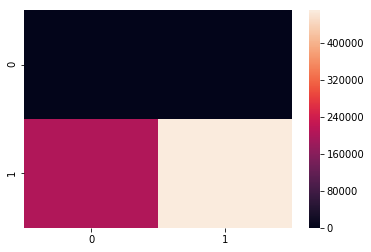

Learning Rate:[0.010000000000000002]
epoch25
train loss: 9.5171471912181e-06
valid loss: 7.945113793539349e-06
accuracy: 86.28488888888889 %
saved


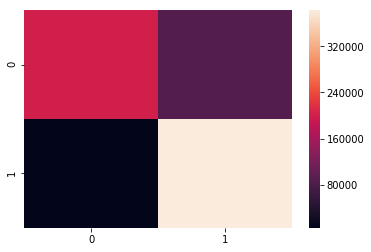

Learning Rate:[0.1]
epoch26
train loss: 7.811402610968798e-06
valid loss: 7.675119377381634e-06
accuracy: 86.32844444444444 %
saved


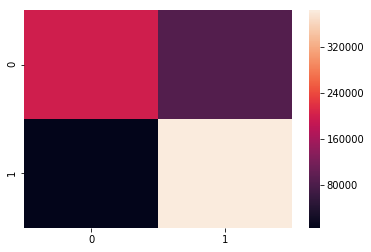

Learning Rate:[0.010000000000000002]
epoch27
train loss: 6.622249202337116e-06
valid loss: 6.197893526405096e-06
accuracy: 84.54237037037036 %


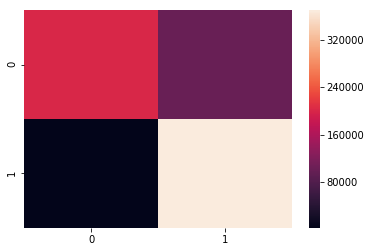

Learning Rate:[0.1]
epoch28
train loss: 6.1644154811801855e-06
valid loss: 6.11413952356088e-06
accuracy: 84.61362962962963 %


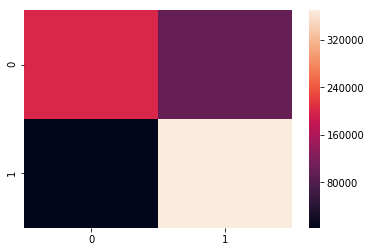

Learning Rate:[0.010000000000000002]
epoch29
train loss: 5.628165126836393e-06
valid loss: 1.5170782717177644e-05
accuracy: 75.3954074074074 %


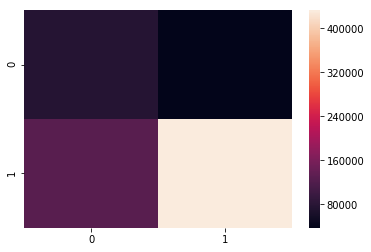

Learning Rate:[0.1]
epoch30
train loss: 1.2775518371199723e-05
valid loss: 5.82865550313727e-06
accuracy: 87.75259259259259 %
saved


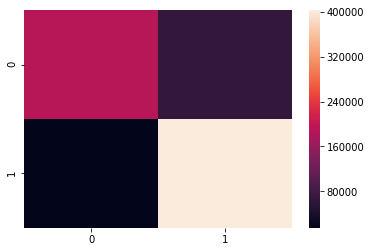

Learning Rate:[0.010000000000000002]
epoch31
train loss: 6.235639830265427e-06
valid loss: 6.81210894981632e-06
accuracy: 83.12533333333333 %


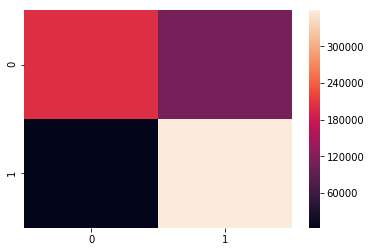

Learning Rate:[0.1]
epoch32
train loss: 6.913435754540842e-06
valid loss: 6.964211479498772e-06
accuracy: 82.73214814814814 %


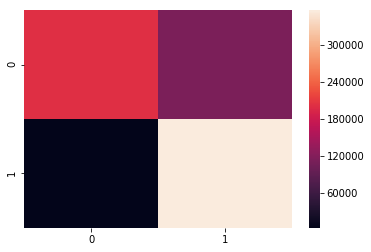

Learning Rate:[0.010000000000000002]
epoch33
train loss: 7.611240107507911e-06
valid loss: 7.425292551488383e-06
accuracy: 80.9357037037037 %


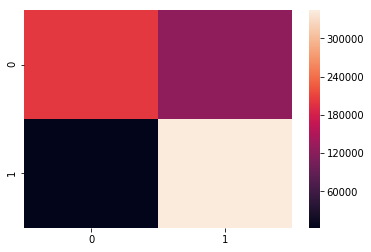

Learning Rate:[0.1]
epoch34
train loss: 7.372628260782221e-06
valid loss: 7.346568054344971e-06
accuracy: 81.07422222222223 %


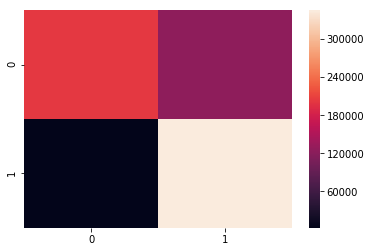

Learning Rate:[0.010000000000000002]
epoch35
train loss: 6.972073606448248e-06
valid loss: 6.888086318213027e-06
accuracy: 81.87911111111111 %


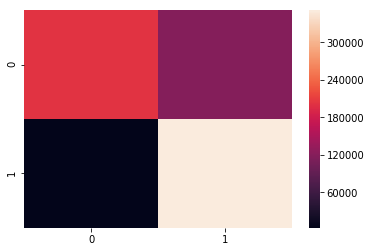

Learning Rate:[0.1]
epoch36
train loss: 6.841314643679652e-06
valid loss: 6.797092737542698e-06
accuracy: 82.10948148148148 %


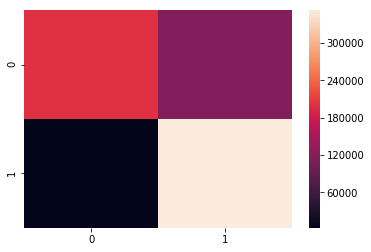

Learning Rate:[0.010000000000000002]
epoch37
train loss: 6.230958206288051e-06
valid loss: 6.150235094537493e-06
accuracy: 84.52592592592593 %


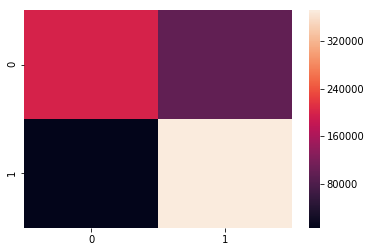

Learning Rate:[0.1]
epoch38
train loss: 6.12967278357246e-06
valid loss: 6.1285395531740505e-06
accuracy: 84.64118518518518 %


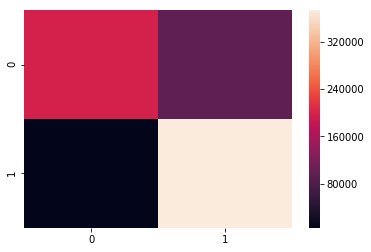

Learning Rate:[0.010000000000000002]
epoch39
train loss: 6.058438884792849e-06
valid loss: 5.9584940572676715e-06
accuracy: 84.24281481481482 %


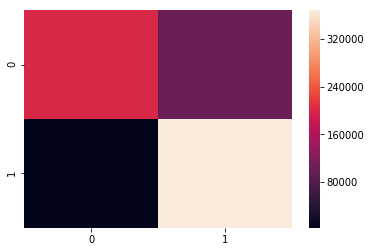

Learning Rate:[0.1]
epoch40
train loss: 5.954515017947415e-06
valid loss: 5.953489107923815e-06
accuracy: 84.24622222222223 %


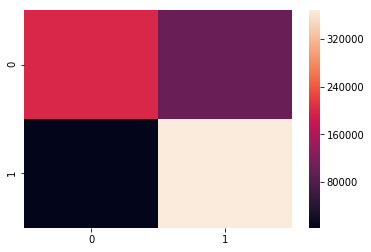

Learning Rate:[0.010000000000000002]
epoch41
train loss: 5.9011940720665734e-06
valid loss: 5.839990080858115e-06
accuracy: 84.50385185185185 %


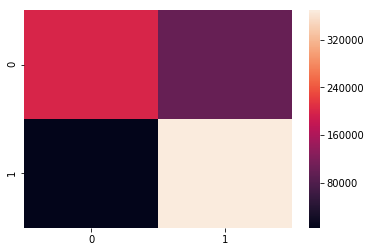

Learning Rate:[0.1]
epoch42
train loss: 5.833822797285393e-06
valid loss: 5.8308005463914014e-06
accuracy: 84.52518518518518 %


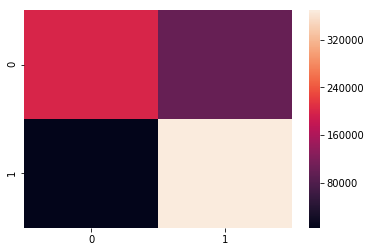

Learning Rate:[0.010000000000000002]
epoch43
train loss: 5.811737992189592e-06
valid loss: 5.866482752026059e-06
accuracy: 84.09037037037037 %


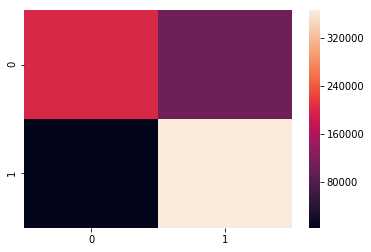

Learning Rate:[0.1]
epoch44
train loss: 5.8771297517523635e-06
valid loss: 5.886766302864999e-06
accuracy: 83.99140740740741 %


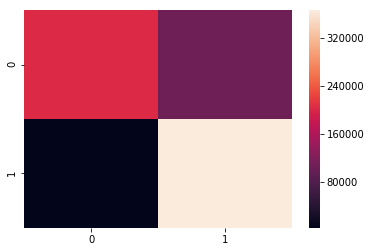

Learning Rate:[0.010000000000000002]
epoch45
train loss: 5.869873348274268e-06
valid loss: 5.835722276970046e-06
accuracy: 83.97392592592593 %


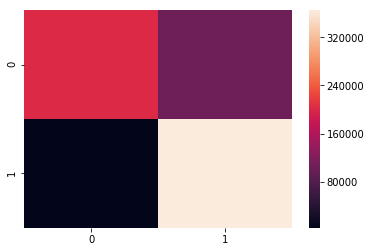

Learning Rate:[0.1]
epoch46
train loss: 5.830992904520826e-06
valid loss: 5.826617780257948e-06
accuracy: 83.98577777777778 %


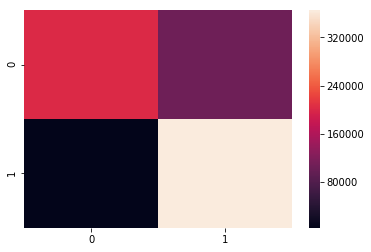

Learning Rate:[0.010000000000000002]
epoch47
train loss: 5.808652986161178e-06
valid loss: 5.8031037042383105e-06
accuracy: 83.97451851851852 %


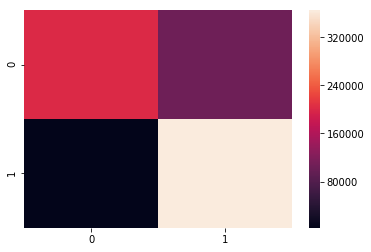

Learning Rate:[0.1]
epoch48
train loss: 5.798136044177227e-06
valid loss: 5.789223450847203e-06
accuracy: 84.02577777777778 %


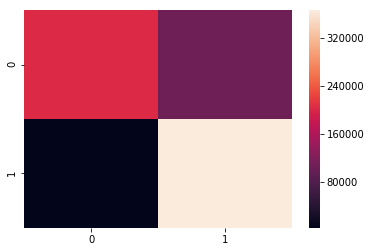

Learning Rate:[0.010000000000000002]
epoch49
train loss: 5.659894668497145e-06
valid loss: 5.59542468181462e-06
accuracy: 84.99481481481482 %


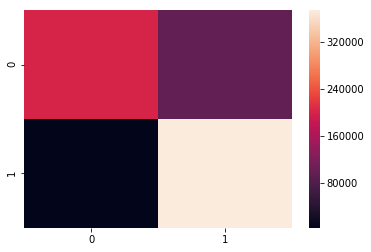

Learning Rate:[0.1]
epoch50
train loss: 5.590531600319082e-06
valid loss: 5.588530257227831e-06
accuracy: 85.04103703703704 %


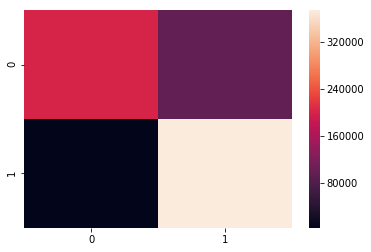

Learning Rate:[0.010000000000000002]
epoch51
train loss: 5.5585828704352025e-06
valid loss: 5.53488644072786e-06
accuracy: 85.39407407407408 %


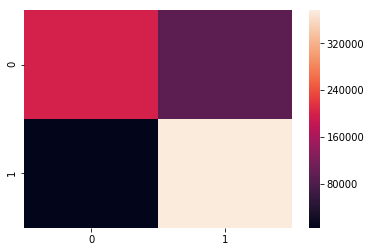

Learning Rate:[0.1]
epoch52
train loss: 5.532933300855802e-06
valid loss: 5.530779162654653e-06
accuracy: 85.4194074074074 %


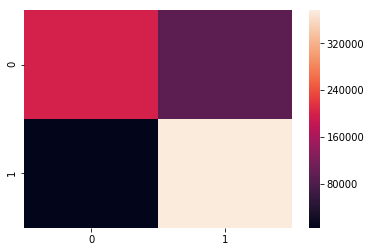

Learning Rate:[0.010000000000000002]
epoch53
train loss: 5.54056032342487e-06
valid loss: 5.597441486315802e-06
accuracy: 84.76459259259259 %


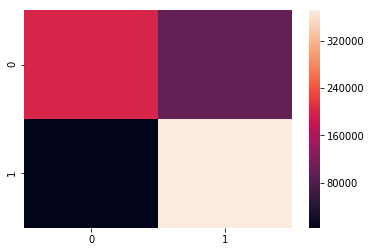

Learning Rate:[0.1]
epoch54
train loss: 5.609852905763546e-06
valid loss: 5.6181420404755045e-06
accuracy: 84.64562962962962 %


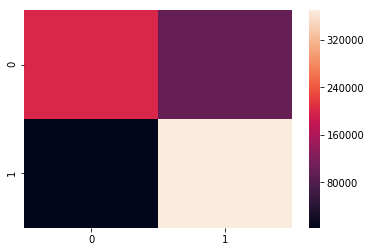

Learning Rate:[0.010000000000000002]
epoch55
train loss: 5.700686415366363e-06
valid loss: 5.7202778407372534e-06
accuracy: 84.07303703703704 %


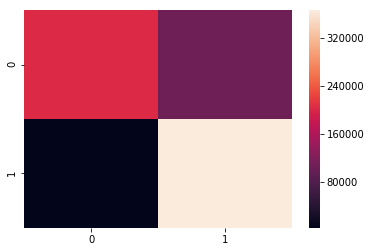

Learning Rate:[0.1]
epoch56
train loss: 5.722298283217242e-06
valid loss: 5.725768005504506e-06
accuracy: 84.05348148148148 %


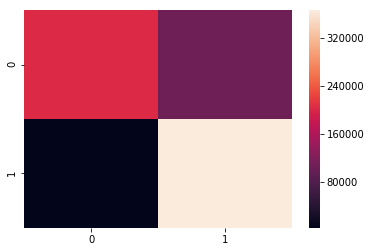

Learning Rate:[0.010000000000000002]
epoch57
train loss: 5.746916485804832e-06
valid loss: 5.777881142421393e-06
accuracy: 83.82133333333334 %


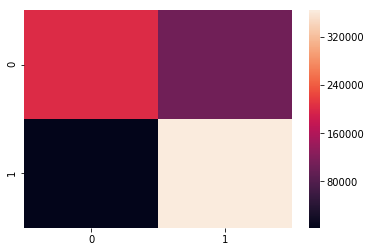

Learning Rate:[0.1]
epoch58
train loss: 5.781403160654008e-06
valid loss: 5.7843108152155764e-06
accuracy: 83.79614814814815 %


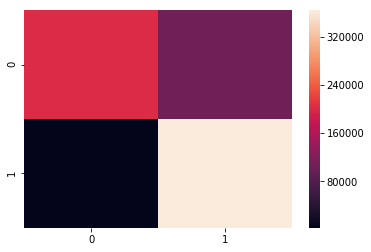

Learning Rate:[0.010000000000000002]
epoch59
train loss: 5.813504685647786e-06
valid loss: 5.832594069943298e-06
accuracy: 83.61392592592593 %


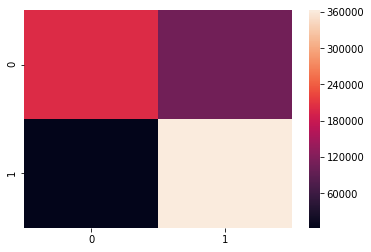

Learning Rate:[0.1]
epoch60
train loss: 5.8342566262581386e-06
valid loss: 5.8350137805973645e-06
accuracy: 83.60488888888888 %


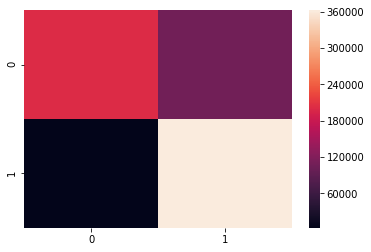

Learning Rate:[0.010000000000000002]
epoch61
train loss: 5.859360953763826e-06
valid loss: 5.8663317759055644e-06
accuracy: 83.48518518518519 %


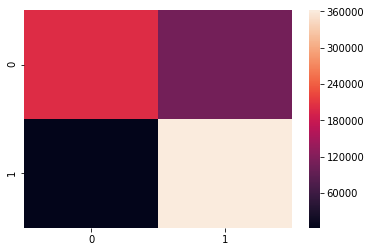

Learning Rate:[0.1]
epoch62
train loss: 5.891460205020849e-06
valid loss: 5.900764790567337e-06
accuracy: 83.37392592592593 %


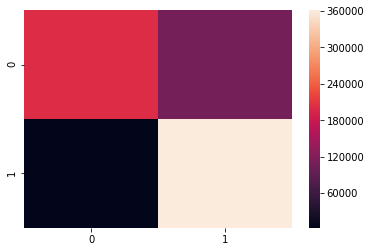

Learning Rate:[0.010000000000000002]
epoch63
train loss: 6.129318535386119e-06
valid loss: 6.25932625553105e-06
accuracy: 82.47288888888889 %


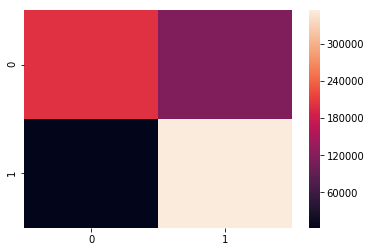

Learning Rate:[0.1]
epoch64
train loss: 6.283285529207205e-06
valid loss: 6.295332241279539e-06
accuracy: 82.37985185185185 %


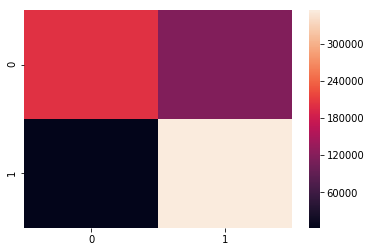

Learning Rate:[0.010000000000000002]
epoch65
train loss: 6.495180514320964e-06
valid loss: 6.557843335031066e-06
accuracy: 81.64459259259259 %


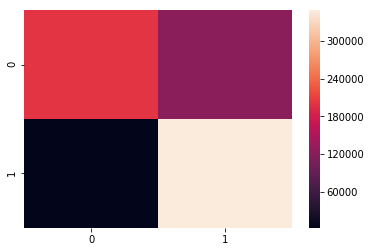

Learning Rate:[0.1]
epoch66
train loss: 6.5670942603901494e-06
valid loss: 6.569012839463539e-06
accuracy: 81.6082962962963 %


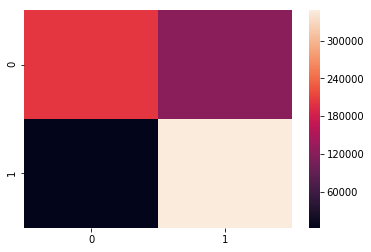

Learning Rate:[0.010000000000000002]
epoch67
train loss: 6.605198450415628e-06
valid loss: 6.614824087591842e-06
accuracy: 81.41303703703704 %


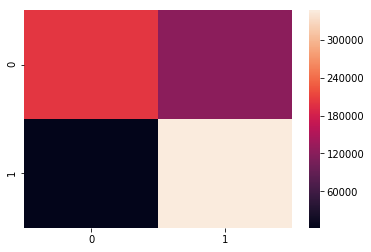

Learning Rate:[0.1]
epoch68
train loss: 6.589587428607047e-06
valid loss: 6.580731678695884e-06
accuracy: 81.49422222222222 %


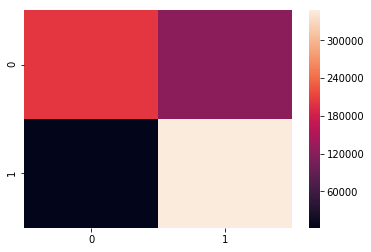

Learning Rate:[0.010000000000000002]
epoch69
train loss: 6.414727977244183e-06
valid loss: 6.396955086529488e-06
accuracy: 81.96014814814815 %


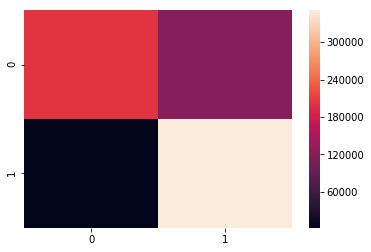

Learning Rate:[0.1]
epoch70
train loss: 6.395469426934142e-06
valid loss: 6.394778210960794e-06
accuracy: 81.96859259259259 %


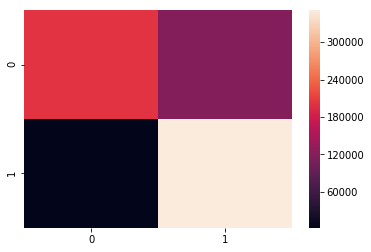

Learning Rate:[0.010000000000000002]
epoch71
train loss: 6.423510967579205e-06
valid loss: 6.425403171306243e-06
accuracy: 81.87037037037037 %


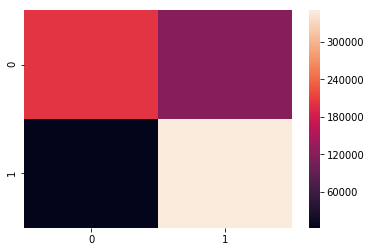

Learning Rate:[0.1]
epoch72
train loss: 6.430032499338267e-06
valid loss: 6.415965799533296e-06
accuracy: 81.89259259259259 %


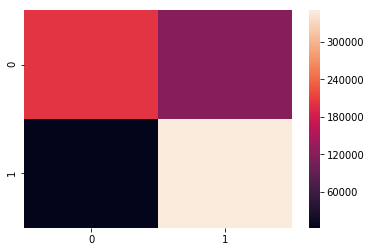

Learning Rate:[0.010000000000000002]
epoch73
train loss: 6.123314960859716e-06
valid loss: 5.905184025323251e-06
accuracy: 83.33525925925926 %


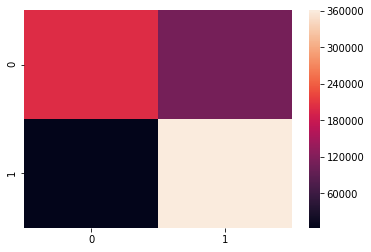

Learning Rate:[0.1]
epoch74
train loss: 5.875354418094503e-06
valid loss: 5.860474630026147e-06
accuracy: 83.48903703703704 %


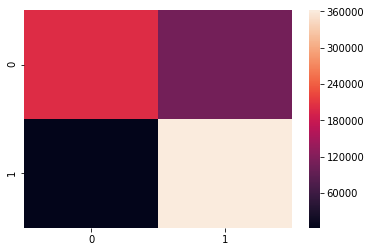

Learning Rate:[0.010000000000000002]
epoch75
train loss: 5.714604412787594e-06
valid loss: 5.66191329198773e-06
accuracy: 84.26488888888889 %


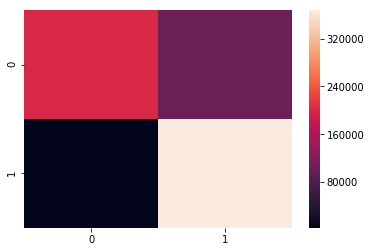

Learning Rate:[0.1]
epoch76
train loss: 5.655258064507507e-06
valid loss: 5.651095307257492e-06
accuracy: 84.30755555555555 %


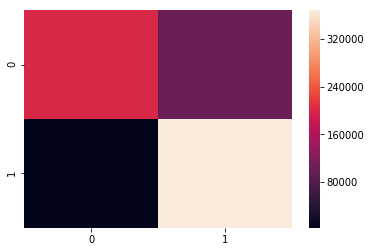

Learning Rate:[0.010000000000000002]
epoch77
train loss: 5.609633262793068e-06
valid loss: 5.589228294411441e-06
accuracy: 84.58933333333334 %


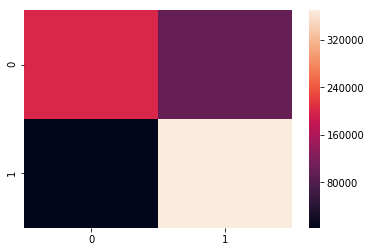

Learning Rate:[0.1]
epoch78
train loss: 5.587598025158513e-06
valid loss: 5.586560746451141e-06
accuracy: 84.6077037037037 %


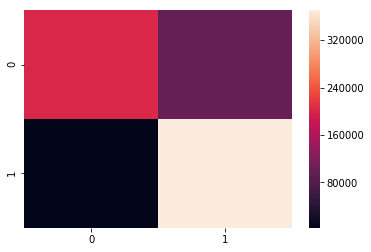

Learning Rate:[0.010000000000000002]
epoch79
train loss: 5.584650807577418e-06
valid loss: 5.5925156630109996e-06
accuracy: 84.61125925925927 %


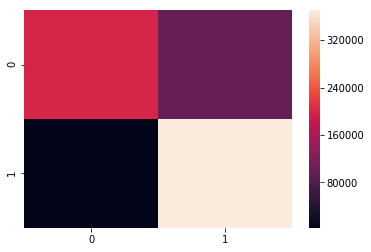

Learning Rate:[0.1]
epoch80
train loss: 5.59312138648238e-06
valid loss: 5.593746664089849e-06
accuracy: 84.60992592592592 %


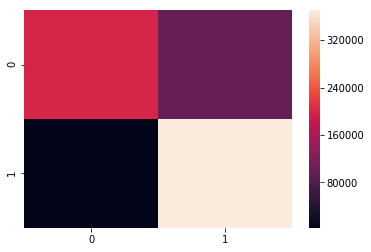

Learning Rate:[0.010000000000000002]
epoch81
train loss: 5.593530204350827e-06
valid loss: 5.592494744632859e-06
accuracy: 84.62637037037038 %


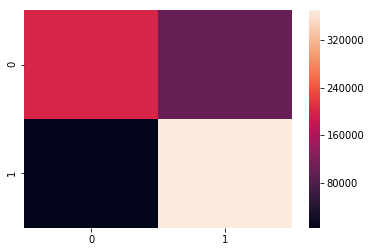

Learning Rate:[0.1]
epoch82
train loss: 5.5924560911080334e-06
valid loss: 5.592275101662381e-06
accuracy: 84.62577777777778 %


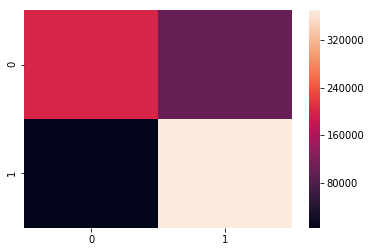

Learning Rate:[0.010000000000000002]
epoch83
train loss: 5.588828571490012e-06
valid loss: 5.577450792770833e-06
accuracy: 84.66637037037037 %


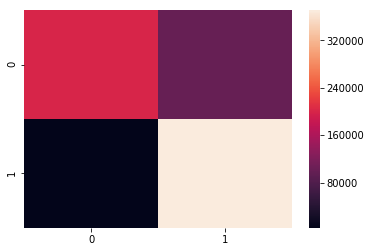

Learning Rate:[0.1]
epoch84
train loss: 5.576704097620677e-06
valid loss: 5.575747763941763e-06
accuracy: 84.6717037037037 %


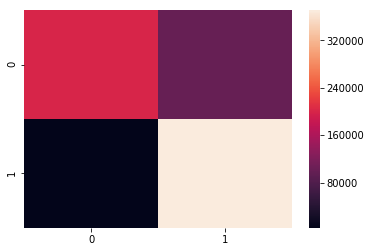

Learning Rate:[0.010000000000000002]
epoch85
train loss: 5.571261681325268e-06
valid loss: 5.562792011915008e-06
accuracy: 84.73170370370372 %


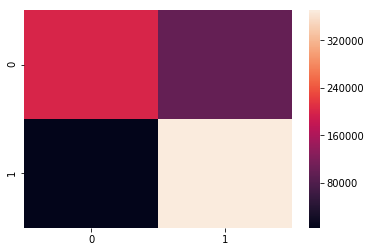

Learning Rate:[0.1]
epoch86
train loss: 5.5696896197332535e-06
valid loss: 5.5747482292645145e-06
accuracy: 84.67185185185186 %


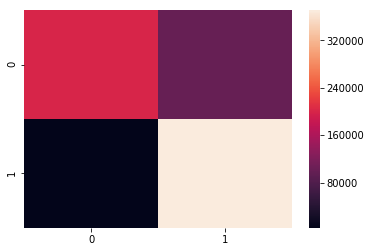

Learning Rate:[0.010000000000000002]
epoch87
train loss: 5.642803444061428e-06
valid loss: 5.685440100933192e-06
accuracy: 84.17733333333334 %


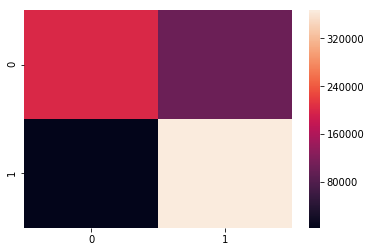

Learning Rate:[0.1]
epoch88
train loss: 5.6809335546859074e-06
valid loss: 5.664819127559895e-06
accuracy: 84.25096296296296 %


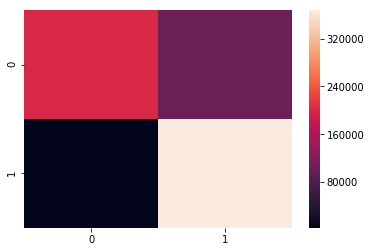

Learning Rate:[0.010000000000000002]
epoch89
train loss: 5.502942258317489e-06
valid loss: 6.9879647526249755e-06
accuracy: 84.76340740740741 %


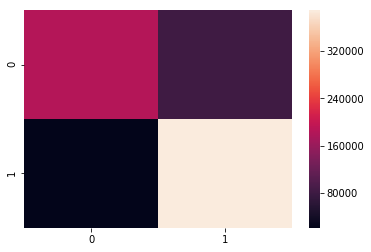

Learning Rate:[0.1]
epoch90
train loss: 7.018588803475723e-06
valid loss: 6.892059900565073e-06
accuracy: 84.80503703703704 %


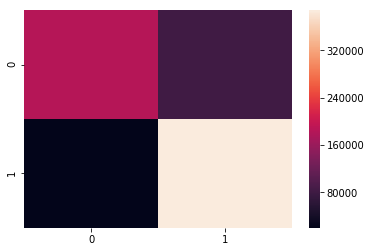

Learning Rate:[0.010000000000000002]
epoch91
train loss: 6.8792242018389516e-06
valid loss: 7.003672180871945e-06
accuracy: 84.61125925925927 %


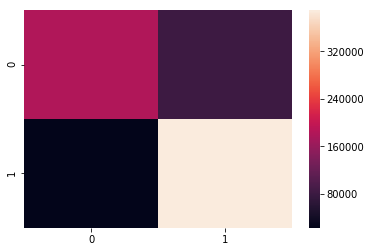

Learning Rate:[0.1]
epoch92
train loss: 7.010391072981292e-06
valid loss: 6.979067165957531e-06
accuracy: 84.58103703703704 %


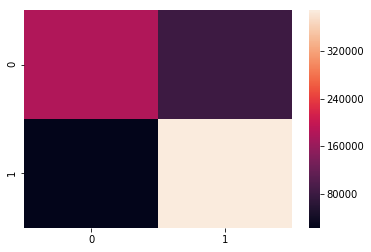

Learning Rate:[0.010000000000000002]
epoch93
train loss: 7.074394943629159e-06
valid loss: 6.82463087287033e-06
accuracy: 84.34592592592593 %


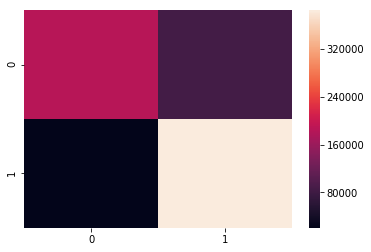

Learning Rate:[0.1]
epoch94
train loss: 6.838036370027112e-06
valid loss: 6.585401479242137e-06
accuracy: 84.36311111111111 %


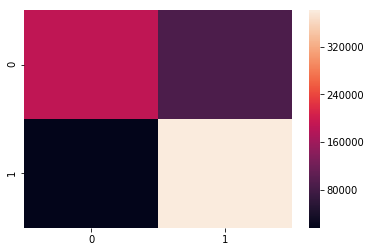

Learning Rate:[0.010000000000000002]
epoch95
train loss: 6.749436579411849e-06
valid loss: 6.6228958530700766e-06
accuracy: 82.6914074074074 %


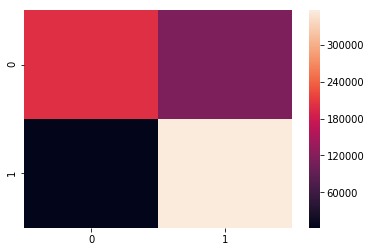

Learning Rate:[0.1]
epoch96
train loss: 6.678788849967532e-06
valid loss: 6.6758743741957005e-06
accuracy: 82.56607407407407 %


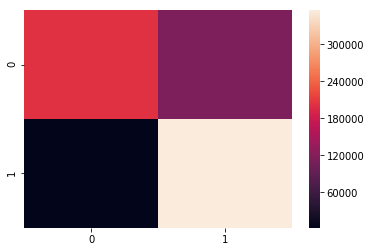

Learning Rate:[0.010000000000000002]
epoch97
train loss: 6.438923264795449e-06
valid loss: 6.171839231683407e-06
accuracy: 83.63881481481481 %


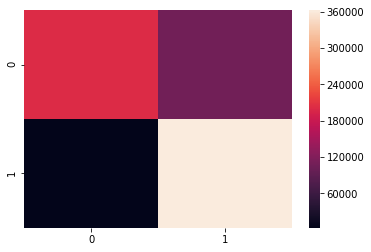

Learning Rate:[0.1]
epoch98
train loss: 6.131118425400928e-06
valid loss: 6.110686626925599e-06
accuracy: 83.79125925925925 %


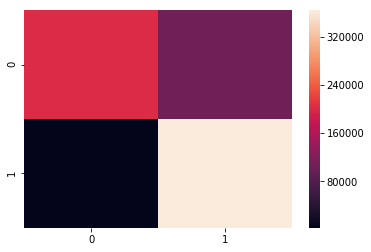

Learning Rate:[0.010000000000000002]
epoch99
train loss: 5.854939445271157e-06
valid loss: 5.721889920096146e-06
accuracy: 84.7922962962963 %


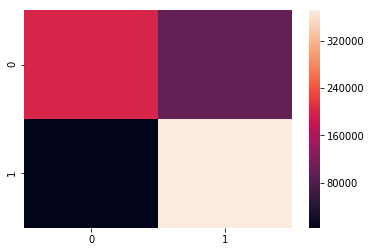

Learning Rate:[0.1]
epoch100
train loss: 5.706348929379601e-06
valid loss: 5.698967925127363e-06
accuracy: 84.86459259259259 %


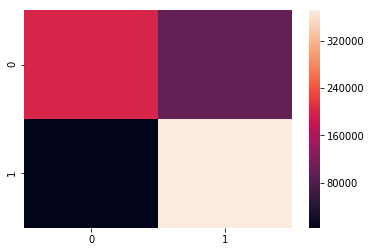

Learning Rate:[0.010000000000000002]
epoch101
train loss: 5.579525804932928e-06
valid loss: 5.539431185752619e-06
accuracy: 85.3117037037037 %


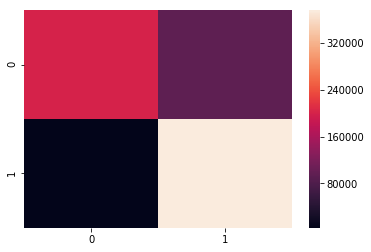

Learning Rate:[0.1]
epoch102
train loss: 5.53314748685807e-06
valid loss: 5.53239851797116e-06
accuracy: 85.33466666666666 %


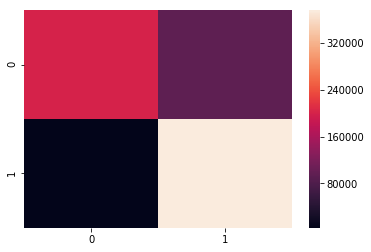

Learning Rate:[0.010000000000000002]
epoch103
train loss: 5.47854506294243e-06
valid loss: 5.485656402015593e-06
accuracy: 85.5128888888889 %


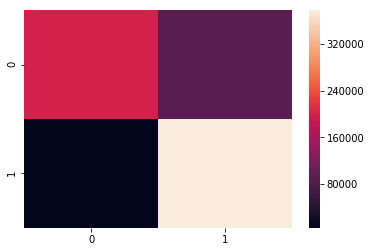

Learning Rate:[0.1]
epoch104
train loss: 5.469987172546098e-06
valid loss: 5.462781700771302e-06
accuracy: 85.6528888888889 %


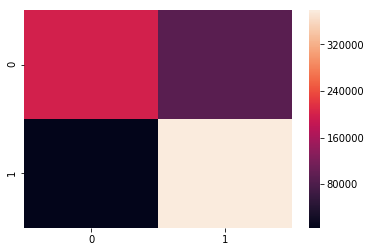

Learning Rate:[0.010000000000000002]
epoch105
train loss: 5.434193099063123e-06
valid loss: 5.9836634136445355e-06
accuracy: 85.92785185185186 %


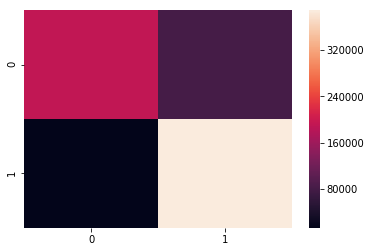

Learning Rate:[0.1]
epoch106
train loss: 5.991384114167886e-06
valid loss: 6.063414275558898e-06
accuracy: 85.92814814814815 %


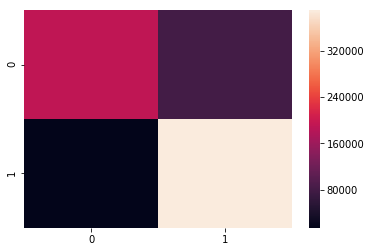

Learning Rate:[0.010000000000000002]
epoch107
train loss: 6.222884167073062e-06
valid loss: 5.5489181249868125e-06
accuracy: 85.22 %


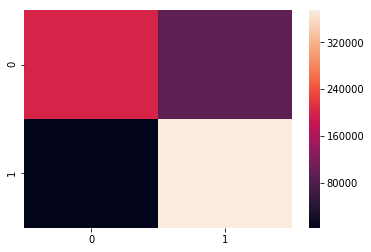

Learning Rate:[0.1]
epoch108
train loss: 5.5703985708532855e-06
valid loss: 5.585744929703651e-06
accuracy: 85.08548148148148 %


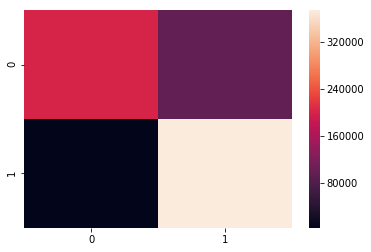

Learning Rate:[0.010000000000000002]
epoch109
train loss: 5.787572717963485e-06
valid loss: 5.910619620408397e-06
accuracy: 84.11348148148147 %


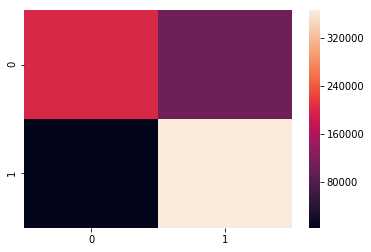

Learning Rate:[0.1]
epoch110
train loss: 5.92266087551252e-06
valid loss: 5.929855433350895e-06
accuracy: 84.04577777777777 %


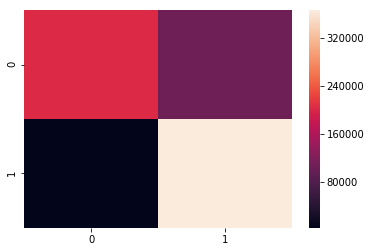

Learning Rate:[0.010000000000000002]
epoch111
train loss: 6.041072538209846e-06
valid loss: 6.0784773268096615e-06
accuracy: 83.52577777777778 %


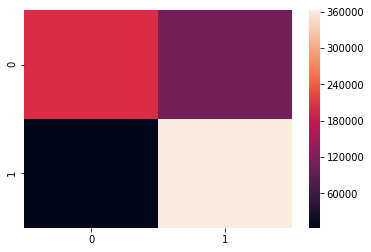

Learning Rate:[0.1]
epoch112
train loss: 6.084484539314872e-06
valid loss: 6.085504992370261e-06
accuracy: 83.49644444444444 %


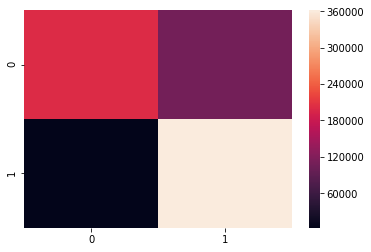

Learning Rate:[0.010000000000000002]
epoch113
train loss: 6.1332698351179715e-06
valid loss: 6.168321306176949e-06
accuracy: 83.14444444444445 %


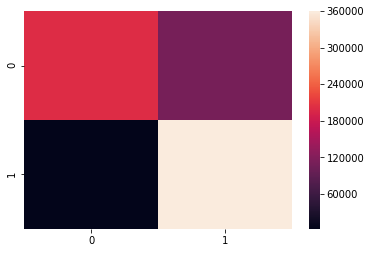

Learning Rate:[0.1]
epoch114
train loss: 6.171262157295132e-06
valid loss: 6.172081157274079e-06
accuracy: 83.124 %


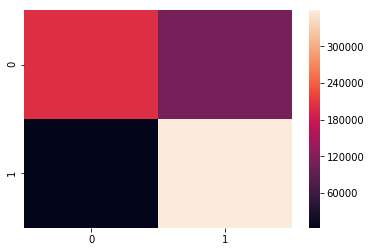

Learning Rate:[0.010000000000000002]
epoch115
train loss: 6.195148671395145e-06
valid loss: 6.223274795047473e-06
accuracy: 82.89081481481482 %


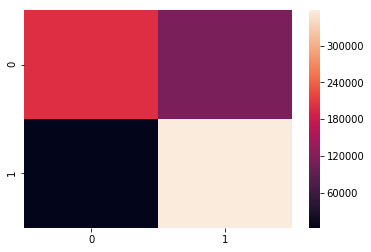

Learning Rate:[0.1]
epoch116
train loss: 6.226292498467956e-06
valid loss: 6.228493020898895e-06
accuracy: 82.87185185185186 %


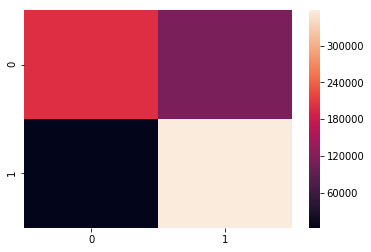

Learning Rate:[0.010000000000000002]
epoch117
train loss: 6.251611466723261e-06
valid loss: 6.25264692644123e-06
accuracy: 82.77362962962962 %


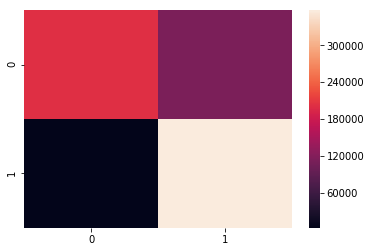

Learning Rate:[0.1]
epoch118
train loss: 6.251888862607302e-06
valid loss: 6.25093343842309e-06
accuracy: 82.77496296296296 %


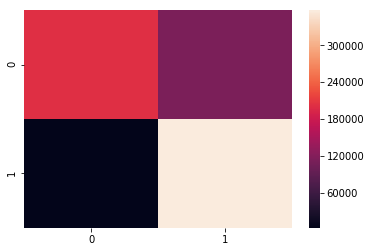

Learning Rate:[0.010000000000000002]
epoch119
train loss: 6.2091385188978165e-06
valid loss: 6.180630862218095e-06
accuracy: 82.964 %


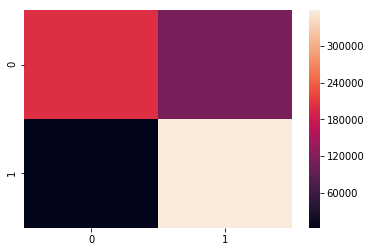

Learning Rate:[0.1]
epoch120
train loss: 6.177158866194077e-06
valid loss: 6.17356454313267e-06
accuracy: 82.98325925925926 %


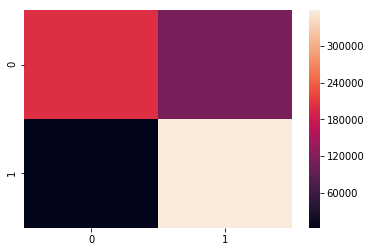

Learning Rate:[0.010000000000000002]
epoch121
train loss: 6.133712304290384e-06
valid loss: 6.10440292803105e-06
accuracy: 83.18799999999999 %


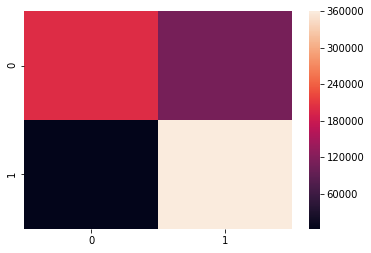

Learning Rate:[0.1]
epoch122
train loss: 6.101398867031094e-06
valid loss: 6.098224730521906e-06
accuracy: 83.2114074074074 %


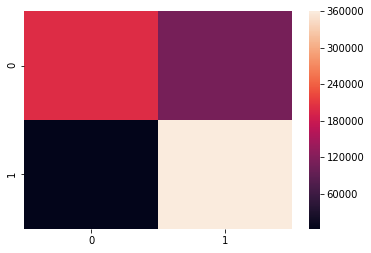

Learning Rate:[0.010000000000000002]
epoch123
train loss: 6.0364372984622605e-06
valid loss: 5.992384558339836e-06
accuracy: 83.54074074074074 %


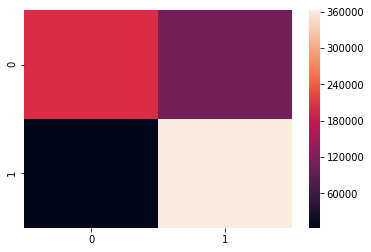

Learning Rate:[0.1]
epoch124
train loss: 5.988068551232573e-06
valid loss: 5.983408300380688e-06
accuracy: 83.57155555555555 %


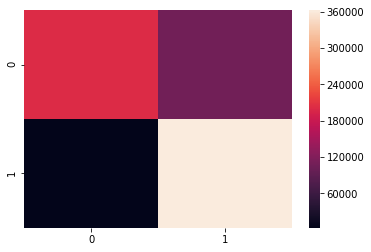

Learning Rate:[0.010000000000000002]
epoch125
train loss: 6.26084465693566e-06
valid loss: 6.4519890656811185e-06
accuracy: 82.15318518518518 %


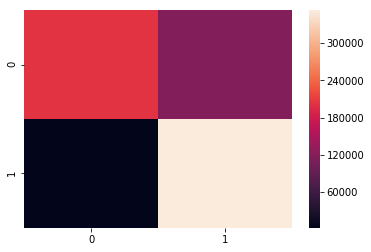

Learning Rate:[0.1]
epoch126
train loss: 6.477172973973211e-06
valid loss: 6.491275144071551e-06
accuracy: 82.0485925925926 %


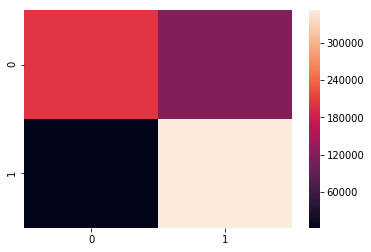

Learning Rate:[0.010000000000000002]
epoch127
train loss: 6.511846095236251e-06
valid loss: 6.389423560904106e-06
accuracy: 82.23437037037037 %


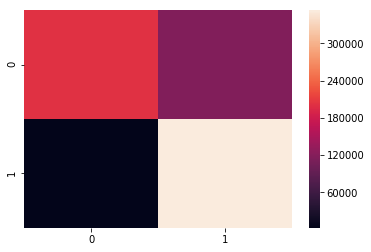

Learning Rate:[0.1]
epoch128
train loss: 6.367514288285747e-06
valid loss: 6.359099643304944e-06
accuracy: 82.31792592592593 %


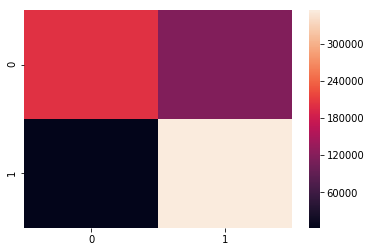

Learning Rate:[0.010000000000000002]
epoch129
train loss: 6.229375230759615e-06
valid loss: 6.1992413975531235e-06
accuracy: 82.83585185185186 %


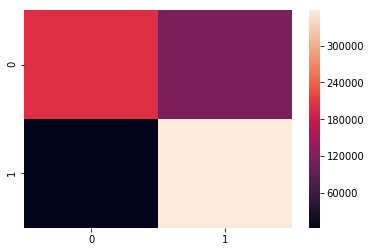

Learning Rate:[0.1]
epoch130
train loss: 6.202919848874444e-06
valid loss: 6.2067792896414176e-06
accuracy: 82.80622222222223 %


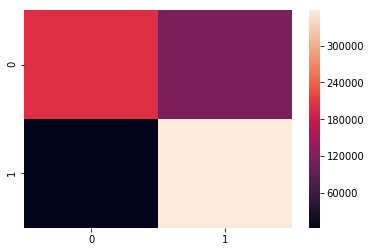

Learning Rate:[0.010000000000000002]
epoch131
train loss: 6.308901902229991e-06
valid loss: 6.352387117658509e-06
accuracy: 82.33392592592593 %


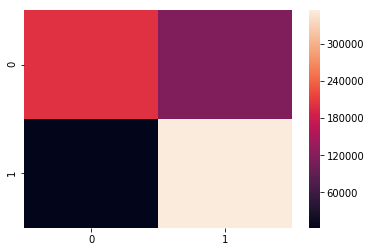

Learning Rate:[0.1]
epoch132
train loss: 6.362819931382546e-06
valid loss: 6.367942660290282e-06
accuracy: 82.29096296296296 %


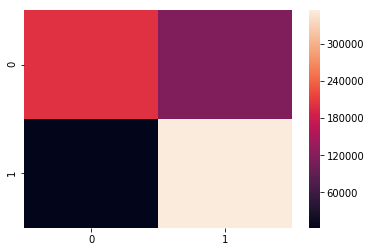

Learning Rate:[0.010000000000000002]
epoch133
train loss: 6.456916253227973e-06
valid loss: 6.498687525891e-06
accuracy: 82.00340740740741 %


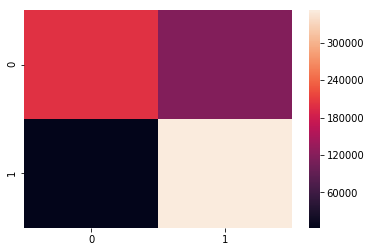

Learning Rate:[0.1]
epoch134
train loss: 6.4908567765087355e-06
valid loss: 6.484489404101623e-06
accuracy: 82.052 %


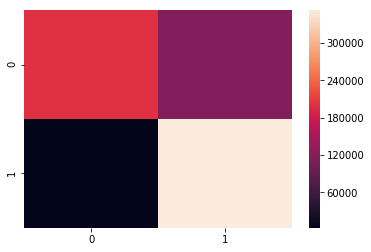

Learning Rate:[0.010000000000000002]
epoch135
train loss: 6.359559847624041e-06
valid loss: 6.319102340057725e-06
accuracy: 82.56340740740741 %


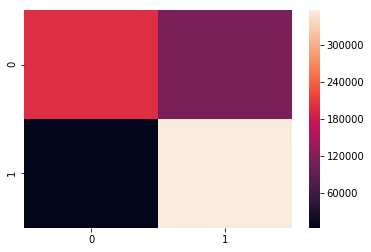

Learning Rate:[0.1]
epoch136
train loss: 6.307230705715483e-06
valid loss: 6.3030233832250815e-06
accuracy: 82.61940740740741 %


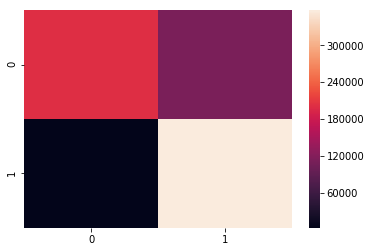

Learning Rate:[0.010000000000000002]
epoch137
train loss: 6.245863914955407e-06
valid loss: 6.1597247622557916e-06
accuracy: 83.14651851851852 %


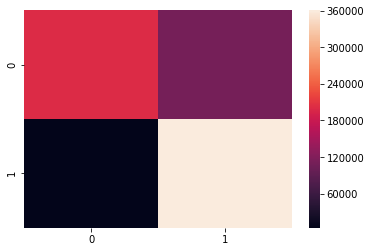

Learning Rate:[0.1]
epoch138
train loss: 6.14801228948636e-06
valid loss: 6.141959602246061e-06
accuracy: 83.21066666666667 %


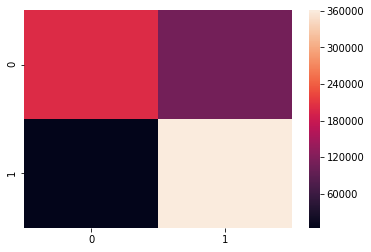

Learning Rate:[0.010000000000000002]
epoch139
train loss: 6.065474735805765e-06
valid loss: 6.04052547714673e-06
accuracy: 83.568 %


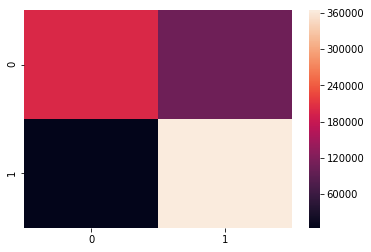

Learning Rate:[0.1]
epoch140
train loss: 6.036563718225807e-06
valid loss: 6.034832949808333e-06
accuracy: 83.59007407407407 %


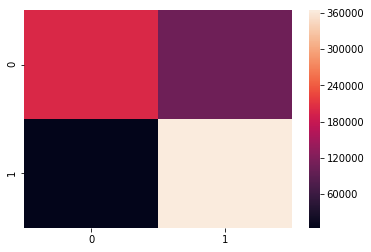

Learning Rate:[0.010000000000000002]
epoch141
train loss: 6.015714916429715e-06
valid loss: 6.000194844091311e-06
accuracy: 83.73451851851851 %


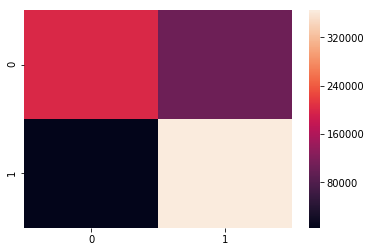

Learning Rate:[0.1]
epoch142
train loss: 5.996502295602113e-06
valid loss: 5.998994765832322e-06
accuracy: 83.76014814814815 %


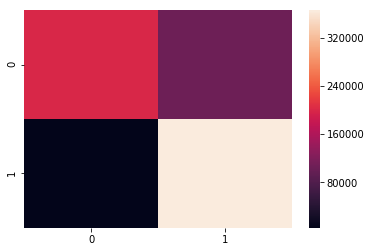

Learning Rate:[0.010000000000000002]
epoch143
train loss: 5.840285666636191e-06
valid loss: 5.952620085736271e-06
accuracy: 85.29570370370371 %


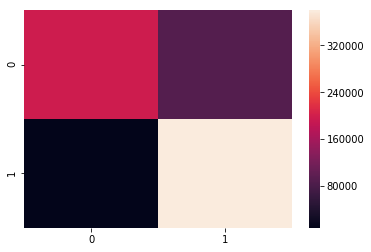

Learning Rate:[0.1]
epoch144
train loss: 5.943309133726871e-06
valid loss: 5.9617659644572996e-06
accuracy: 85.49896296296296 %


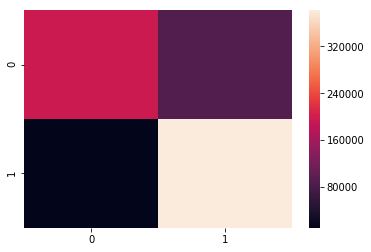

Learning Rate:[0.010000000000000002]
epoch145
train loss: 5.94815128351911e-06
valid loss: 6.228711754374672e-06
accuracy: 86.61022222222222 %


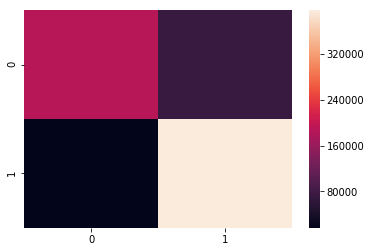

Learning Rate:[0.1]
epoch146
train loss: 6.234921329451026e-06
valid loss: 6.246999873837922e-06
accuracy: 86.68148148148148 %


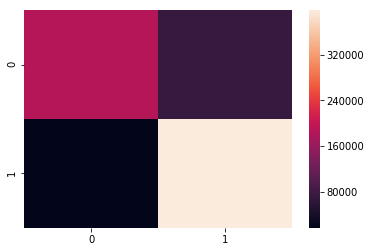

Learning Rate:[0.010000000000000002]
epoch147
train loss: 6.293651495070662e-06
valid loss: 6.417520125978626e-06
accuracy: 87.35955555555556 %


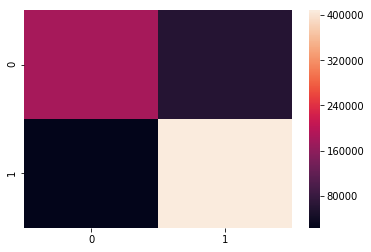

Learning Rate:[0.1]
epoch148
train loss: 6.424409548344556e-06
valid loss: 6.441564892156748e-06
accuracy: 87.40192592592592 %


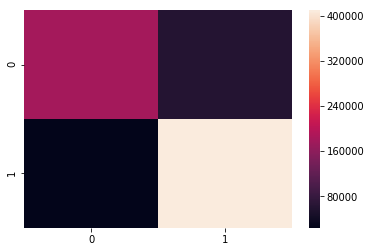

Learning Rate:[0.010000000000000002]
epoch149
train loss: 6.612117431359366e-06
valid loss: 6.7617525019159075e-06
accuracy: 87.48785185185184 %


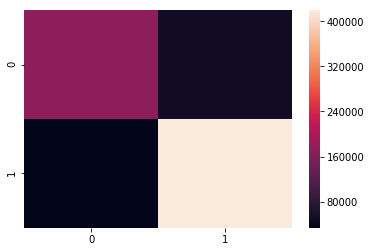

Learning Rate:[0.1]
epoch150
train loss: 6.768436833226588e-06
valid loss: 6.660865892627044e-06
accuracy: 87.38177777777778 %


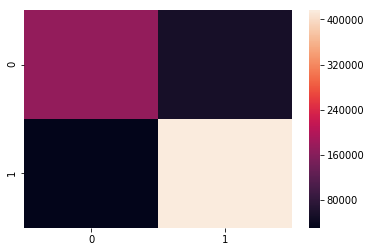

Learning Rate:[0.010000000000000002]
epoch151
train loss: 6.979866611800389e-06
valid loss: 6.859368113509845e-06
accuracy: 86.34948148148148 %


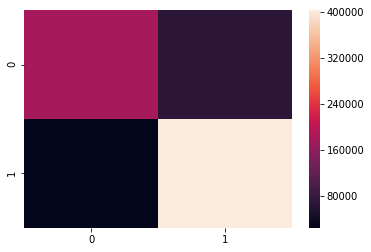

Learning Rate:[0.1]
epoch152
train loss: 6.8800695771642495e-06
valid loss: 6.8698000177391805e-06
accuracy: 86.47348148148149 %


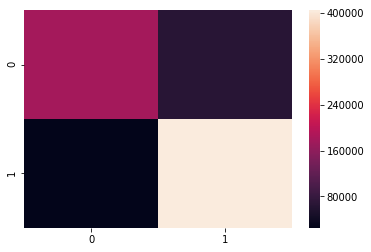

Learning Rate:[0.010000000000000002]
epoch153
train loss: 6.950183887965977e-06
valid loss: 6.9023672040202655e-06
accuracy: 87.26844444444446 %


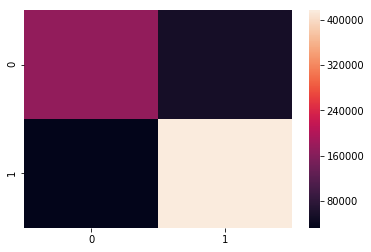

Learning Rate:[0.1]
epoch154
train loss: 6.908319846843369e-06
valid loss: 6.918249709997326e-06
accuracy: 87.26518518518519 %


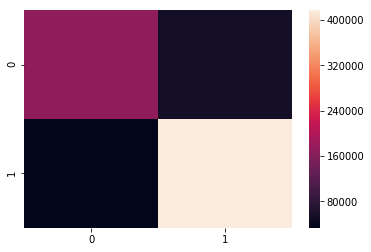

Learning Rate:[0.010000000000000002]
epoch155
train loss: 6.89086300553754e-06
valid loss: 6.7752825998468325e-06
accuracy: 87.63851851851851 %


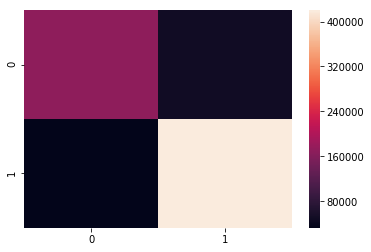

Learning Rate:[0.1]
epoch156
train loss: 6.773607310606167e-06
valid loss: 6.770261734345695e-06
accuracy: 87.65866666666666 %


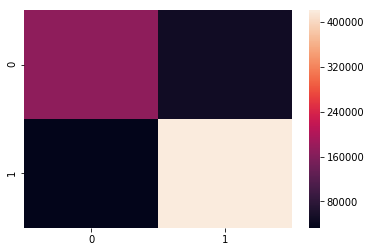

Learning Rate:[0.010000000000000002]
epoch157
train loss: 6.7820751610270236e-06
valid loss: 7.674995686102193e-06
accuracy: 86.39096296296296 %


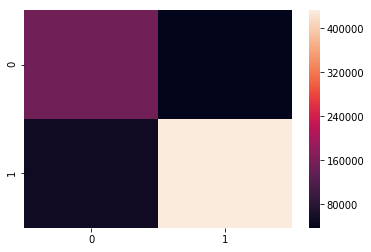

Learning Rate:[0.1]
epoch158
train loss: 7.712577826168854e-06
valid loss: 7.688725418120157e-06
accuracy: 86.35748148148149 %


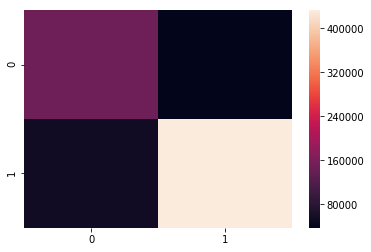

Learning Rate:[0.010000000000000002]
epoch159
train loss: 8.064857865974773e-06
valid loss: 7.682896466576494e-06
accuracy: 86.61496296296296 %


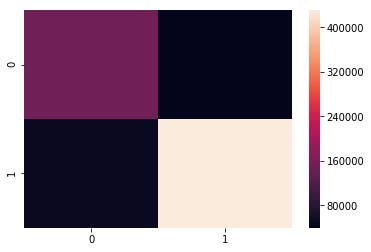

Learning Rate:[0.1]
epoch160
train loss: 7.724099305050913e-06
valid loss: 7.699029083596542e-06
accuracy: 86.63037037037037 %


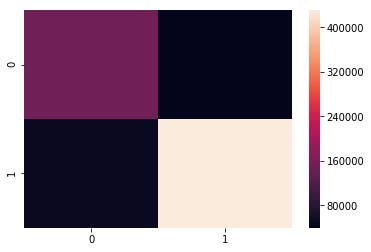

Learning Rate:[0.010000000000000002]
epoch161
train loss: 7.96236145106377e-06
valid loss: 7.712726983299945e-06
accuracy: 86.73051851851852 %


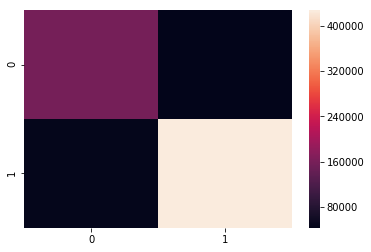

Learning Rate:[0.1]
epoch162
train loss: 7.693403858866077e-06
valid loss: 7.559302503068466e-06
accuracy: 87.01762962962964 %


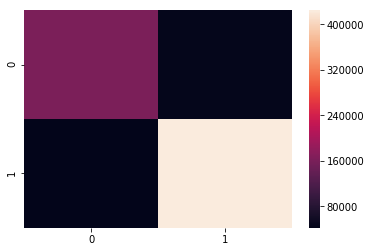

Learning Rate:[0.010000000000000002]
epoch163
train loss: 7.289704626600724e-06
valid loss: 6.902908808115171e-06
accuracy: 87.02562962962963 %


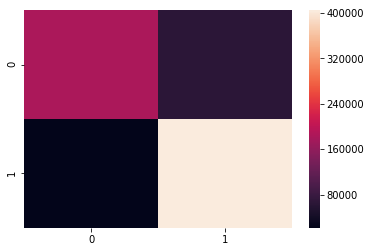

Learning Rate:[0.1]
epoch164
train loss: 6.878262411191827e-06
valid loss: 6.85503573549795e-06
accuracy: 86.97288888888889 %


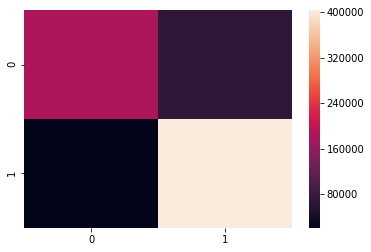

Learning Rate:[0.010000000000000002]
epoch165
train loss: 6.5911622186831664e-06
valid loss: 6.510862021968933e-06
accuracy: 86.52162962962963 %


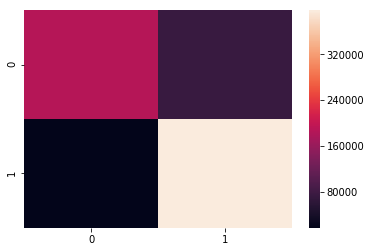

Learning Rate:[0.1]
epoch166
train loss: 6.496323294413742e-06
valid loss: 6.489552106359042e-06
accuracy: 86.49066666666667 %


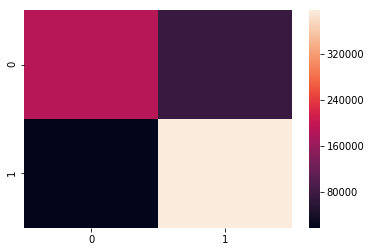

Learning Rate:[0.010000000000000002]
epoch167
train loss: 6.38555229670601e-06
valid loss: 6.352724994940218e-06
accuracy: 86.26014814814815 %


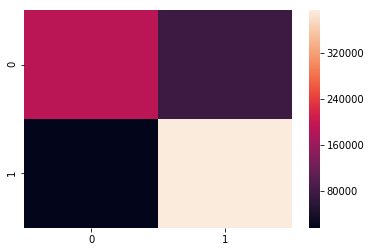

Learning Rate:[0.1]
epoch168
train loss: 6.346507689158898e-06
valid loss: 6.342686447169399e-06
accuracy: 86.25244444444445 %


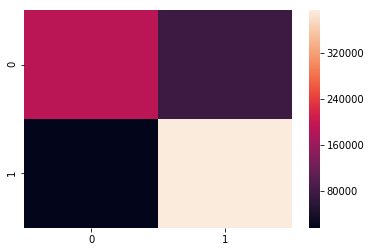

Learning Rate:[0.010000000000000002]
epoch169
train loss: 6.384697826433694e-06
valid loss: 6.390127509803278e-06
accuracy: 85.27733333333333 %


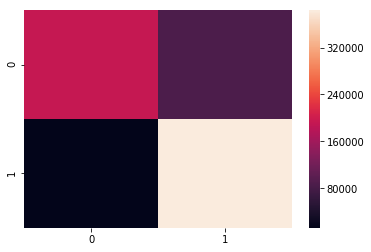

Learning Rate:[0.1]
epoch170
train loss: 6.416732503566891e-06
valid loss: 6.392810973920859e-06
accuracy: 85.1237037037037 %


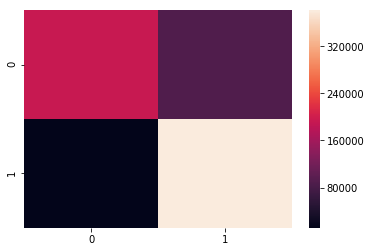

Learning Rate:[0.010000000000000002]
epoch171
train loss: 6.750472493877169e-06
valid loss: 6.72724991090945e-06
accuracy: 83.38918518518518 %


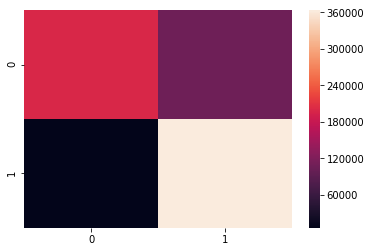

Learning Rate:[0.1]
epoch172
train loss: 6.743429366906639e-06
valid loss: 6.726638275722507e-06
accuracy: 83.3397037037037 %


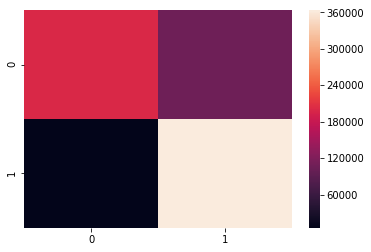

Learning Rate:[0.010000000000000002]
epoch173
train loss: 6.510574621643173e-06
valid loss: 6.442610356316436e-06
accuracy: 83.86 %


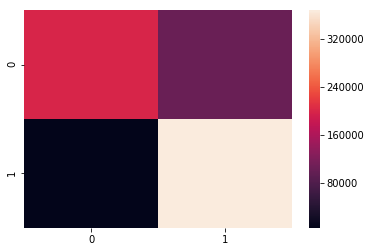

Learning Rate:[0.1]
epoch174
train loss: 6.430001121771056e-06
valid loss: 6.4264795582857914e-06
accuracy: 83.88696296296297 %


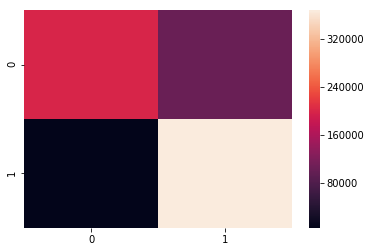

Learning Rate:[0.010000000000000002]
epoch175
train loss: 6.359987764881225e-06
valid loss: 6.323173238342861e-06
accuracy: 84.06577777777777 %


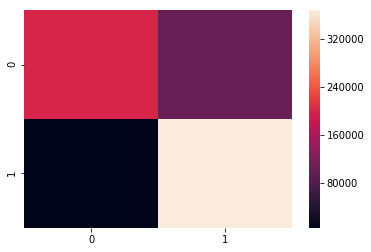

Learning Rate:[0.1]
epoch176
train loss: 6.319605745375156e-06
valid loss: 6.316855433396995e-06
accuracy: 84.07644444444445 %


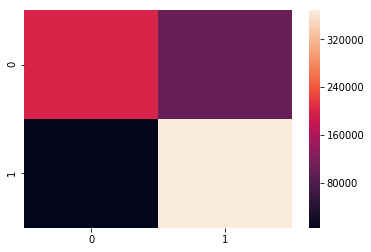

Learning Rate:[0.010000000000000002]
epoch177
train loss: 6.287375981628429e-06
valid loss: 6.266467607929371e-06
accuracy: 84.20385185185185 %


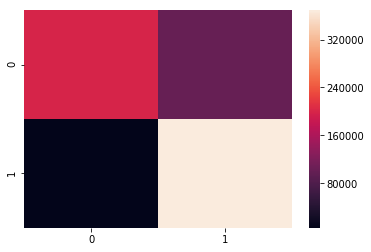

Learning Rate:[0.1]
epoch178
train loss: 6.265146566875046e-06
valid loss: 6.262887836783193e-06
accuracy: 84.21718518518519 %


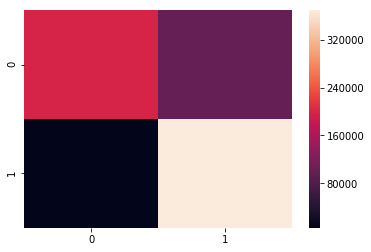

Learning Rate:[0.010000000000000002]
epoch179
train loss: 6.256359938561218e-06
valid loss: 6.244303676794516e-06
accuracy: 84.29777777777778 %


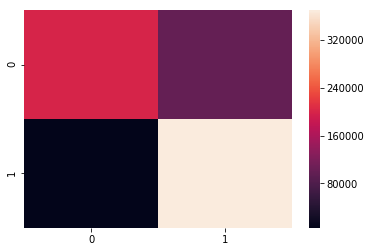

Learning Rate:[0.1]
epoch180
train loss: 6.244169981073355e-06
valid loss: 6.243348707357654e-06
accuracy: 84.30148148148147 %


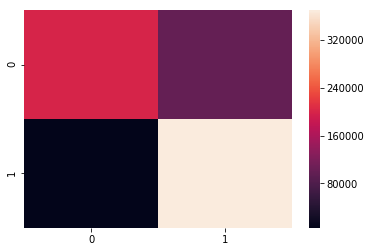

Learning Rate:[0.010000000000000002]
epoch181
train loss: 6.256126653170213e-06
valid loss: 6.248857971513644e-06
accuracy: 84.20607407407408 %


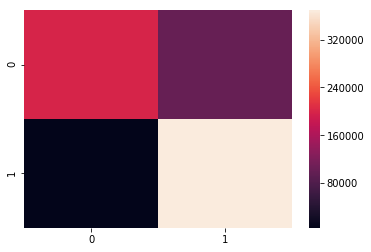

Learning Rate:[0.1]
epoch182
train loss: 6.248956651688786e-06
valid loss: 6.24830727247172e-06
accuracy: 84.20014814814814 %


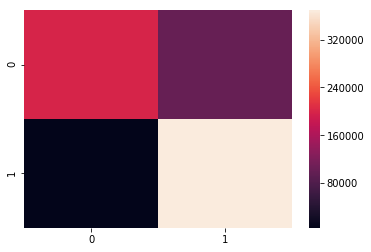

Learning Rate:[0.010000000000000002]
epoch183
train loss: 6.253230367292417e-06
valid loss: 6.254187610466033e-06
accuracy: 84.14059259259258 %


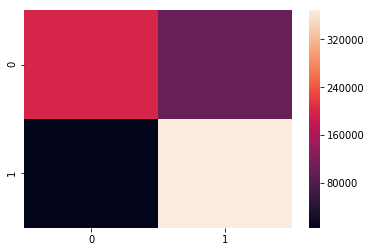

Learning Rate:[0.1]
epoch184
train loss: 6.254808340599993e-06
valid loss: 6.254948857531417e-06
accuracy: 84.13659259259259 %


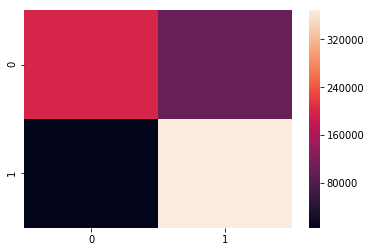

Learning Rate:[0.010000000000000002]
epoch185
train loss: 6.207460955920396e-06
valid loss: 6.1805367295164615e-06
accuracy: 84.4688888888889 %


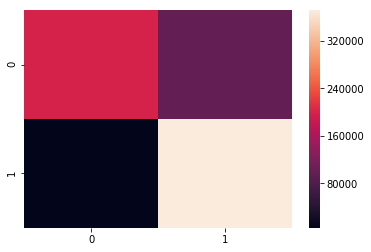

Learning Rate:[0.1]
epoch186
train loss: 6.178677722346038e-06
valid loss: 6.176648184919031e-06
accuracy: 84.49318518518518 %


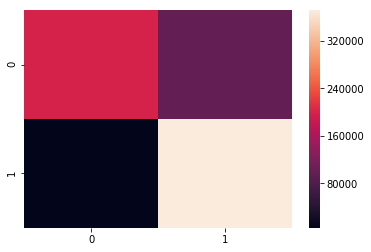

Learning Rate:[0.010000000000000002]
epoch187
train loss: 6.185623988130828e-06
valid loss: 6.18381909589516e-06
accuracy: 84.56977777777777 %


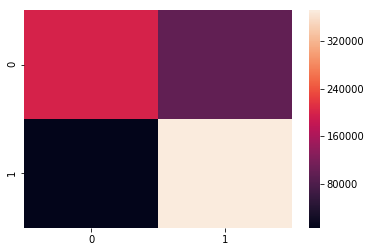

Learning Rate:[0.1]
epoch188
train loss: 6.181959179230034e-06
valid loss: 6.193604349391535e-06
accuracy: 84.6162962962963 %


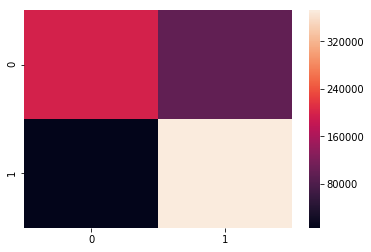

Learning Rate:[0.010000000000000002]
epoch189
train loss: 6.17848900219542e-06
valid loss: 6.242309154913528e-06
accuracy: 85.09674074074074 %


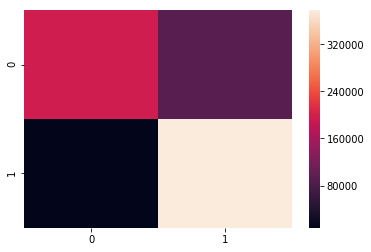

Learning Rate:[0.1]
epoch190
train loss: 6.246531484066509e-06
valid loss: 6.2463518588629086e-06
accuracy: 85.09022222222222 %


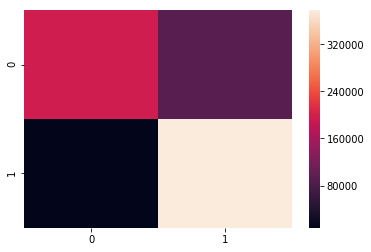

Learning Rate:[0.010000000000000002]
epoch191
train loss: 6.2760436776443385e-06
valid loss: 6.271015081438236e-06
accuracy: 85.08948148148147 %


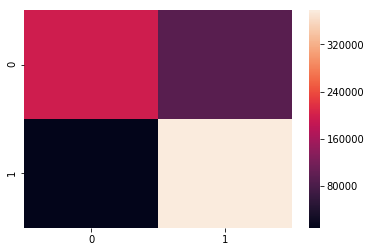

Learning Rate:[0.1]
epoch192
train loss: 6.280619345488958e-06
valid loss: 6.277976808632957e-06
accuracy: 85.012 %


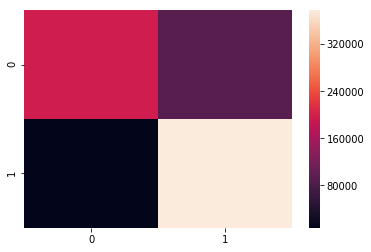

Learning Rate:[0.010000000000000002]
epoch193
train loss: 6.367473361024167e-06
valid loss: 6.36940876574954e-06
accuracy: 84.33229629629629 %


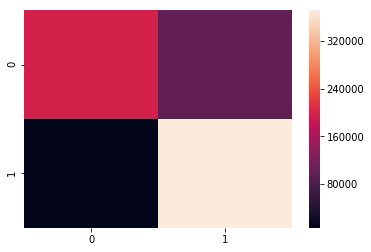

Learning Rate:[0.1]
epoch194
train loss: 6.376311375788646e-06
valid loss: 6.377361387421843e-06
accuracy: 84.28340740740741 %


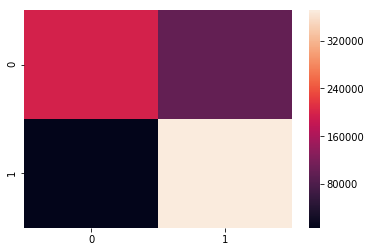

Learning Rate:[0.010000000000000002]
epoch195
train loss: 6.391417628037743e-06
valid loss: 6.33570016361773e-06
accuracy: 84.15081481481481 %


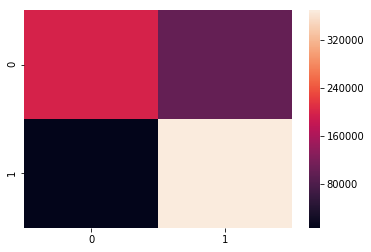

Learning Rate:[0.1]
epoch196
train loss: 6.333204055408714e-06
valid loss: 6.3360353124153335e-06
accuracy: 84.05259259259259 %


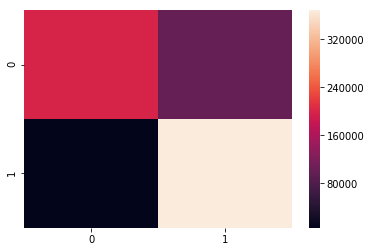

Learning Rate:[0.010000000000000002]
epoch197
train loss: 6.414920335373608e-06
valid loss: 6.503992608486442e-06
accuracy: 83.02918518518518 %


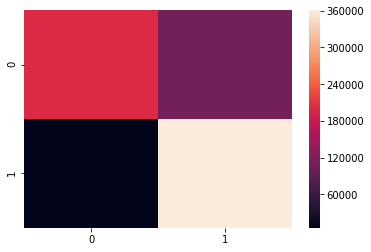

Learning Rate:[0.1]
epoch198
train loss: 6.508229489554651e-06
valid loss: 6.515542736451607e-06
accuracy: 82.95481481481481 %


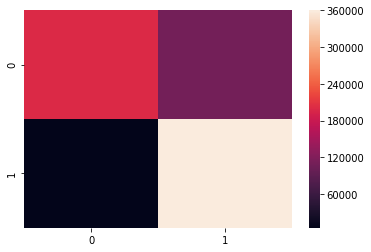

Learning Rate:[0.010000000000000002]
epoch199
train loss: 6.578240117960377e-06
valid loss: 6.632782060478348e-06
accuracy: 82.34325925925926 %


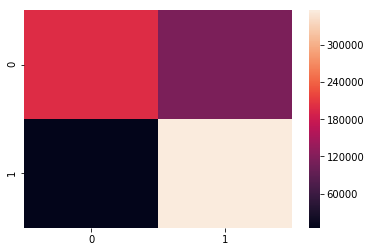

Learning Rate:[0.1]
epoch200
train loss: 6.636709258600604e-06
valid loss: 6.63944683765294e-06
accuracy: 82.31111111111112 %


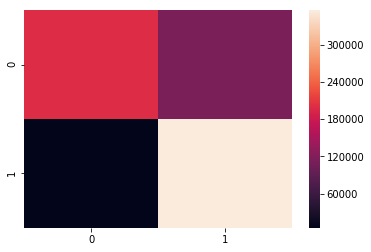

Learning Rate:[0.010000000000000002]
epoch201
train loss: 6.640793799306266e-06
valid loss: 6.655141987721436e-06
accuracy: 82.22148148148149 %


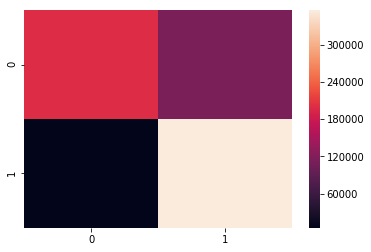

Learning Rate:[0.1]
epoch202
train loss: 6.654722710663918e-06
valid loss: 6.655622200923972e-06
accuracy: 82.21851851851851 %


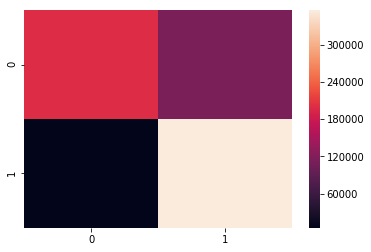

Learning Rate:[0.010000000000000002]
epoch203
train loss: 6.64420213070116e-06
valid loss: 6.646122528763954e-06
accuracy: 82.25377777777778 %


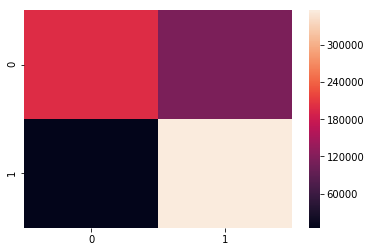

Learning Rate:[0.1]
epoch204
train loss: 6.646203473792411e-06
valid loss: 6.646557267231401e-06
accuracy: 82.25481481481481 %


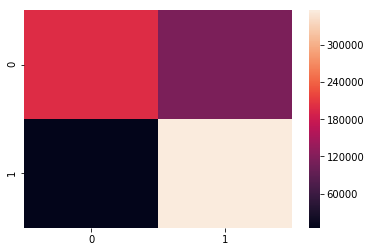

Learning Rate:[0.010000000000000002]
epoch205
train loss: 6.650747309322469e-06
valid loss: 6.643141205131542e-06
accuracy: 82.28933333333333 %


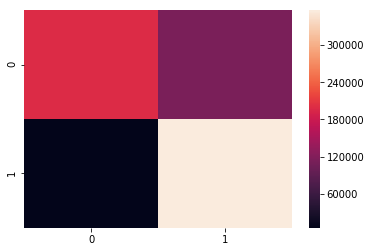

Learning Rate:[0.1]
epoch206
train loss: 6.6435918597562704e-06
valid loss: 6.631506948906463e-06
accuracy: 82.34977777777777 %


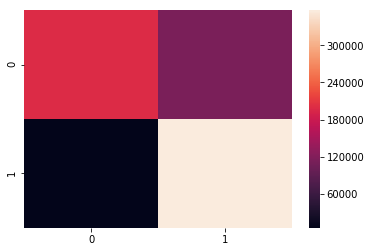

Learning Rate:[0.010000000000000002]
epoch207
train loss: 6.42572467768332e-06
valid loss: 6.342104370560264e-06
accuracy: 83.87955555555556 %


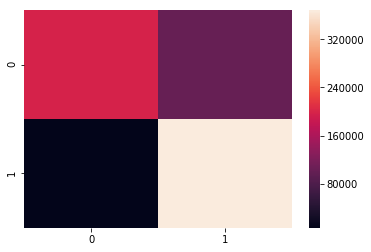

Learning Rate:[0.1]
epoch208
train loss: 6.332483280857559e-06
valid loss: 6.330245923891198e-06
accuracy: 83.95481481481481 %


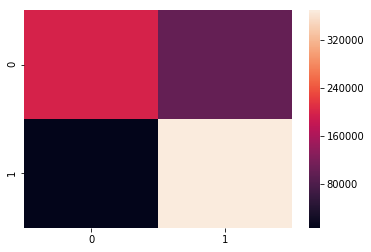

Learning Rate:[0.010000000000000002]
epoch209
train loss: 6.299448614299763e-06
valid loss: 6.272825430642115e-06
accuracy: 84.39259259259259 %


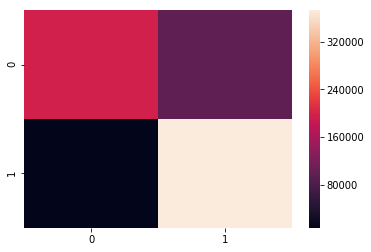

Learning Rate:[0.1]
epoch210
train loss: 6.272954124142416e-06
valid loss: 6.269426194194239e-06
accuracy: 84.41585185185185 %


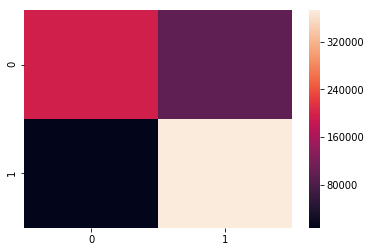

Learning Rate:[0.010000000000000002]
epoch211
train loss: 6.29277292318875e-06
valid loss: 6.261046110012103e-06
accuracy: 84.42548148148148 %


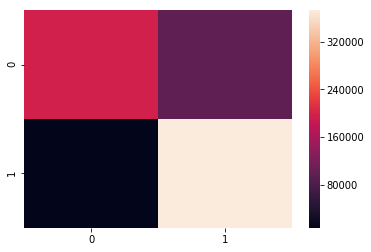

Learning Rate:[0.1]
epoch212
train loss: 6.288871645665495e-06
valid loss: 6.294765626080334e-06
accuracy: 84.24681481481483 %


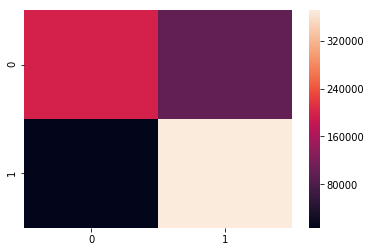

Learning Rate:[0.010000000000000002]
epoch213
train loss: 6.514614142361097e-06
valid loss: 6.607999239349738e-06
accuracy: 82.95437037037037 %


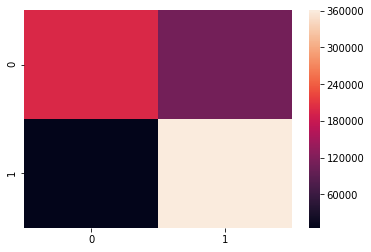

Learning Rate:[0.1]
epoch214
train loss: 6.614719950448489e-06
valid loss: 6.597148058062885e-06
accuracy: 82.98548148148149 %


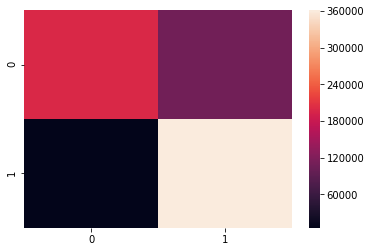

Learning Rate:[0.010000000000000002]
epoch215
train loss: 6.3798893279454205e-06
valid loss: 6.275568921410013e-06
accuracy: 84.04888888888888 %


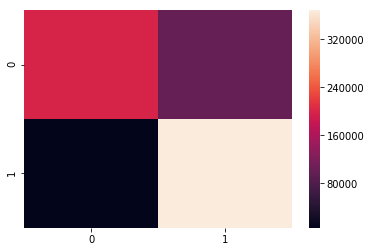

Learning Rate:[0.1]
epoch216
train loss: 6.266427135415142e-06
valid loss: 6.260145710257348e-06
accuracy: 84.10977777777778 %


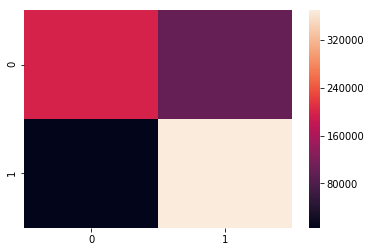

Learning Rate:[0.010000000000000002]
epoch217
train loss: 6.213433607626939e-06
valid loss: 6.186639438965358e-06
accuracy: 84.48148148148148 %


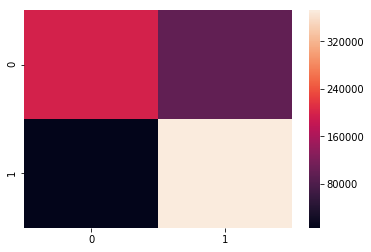

Learning Rate:[0.1]
epoch218
train loss: 6.195481546455994e-06
valid loss: 6.166384991956875e-06
accuracy: 84.35955555555556 %


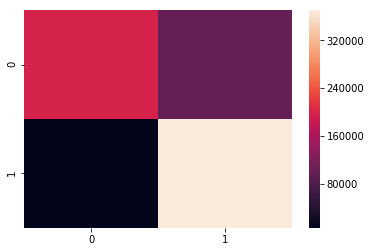

Learning Rate:[0.010000000000000002]
epoch219
train loss: 6.244482392503414e-06
valid loss: 6.259711426537251e-06
accuracy: 83.19007407407408 %


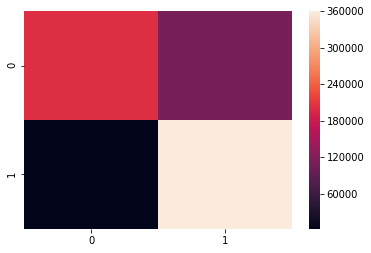

Learning Rate:[0.1]
epoch220
train loss: 6.272285645536613e-06
valid loss: 6.278986347751925e-06
accuracy: 83.10592592592593 %


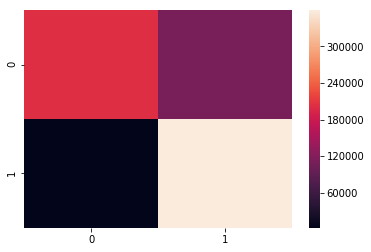

Learning Rate:[0.010000000000000002]
epoch221
train loss: 6.335314992611529e-06
valid loss: 6.319916792563163e-06
accuracy: 82.81614814814814 %


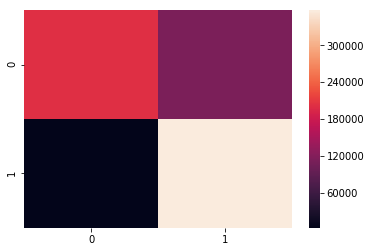

Learning Rate:[0.1]
epoch222
train loss: 6.3105776462180074e-06
valid loss: 6.310419394139899e-06
accuracy: 82.84296296296296 %


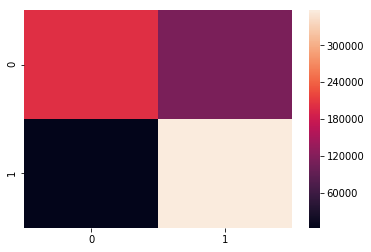

Learning Rate:[0.010000000000000002]
epoch223
train loss: 6.233856765902601e-06
valid loss: 6.207984824868618e-06
accuracy: 83.10651851851853 %


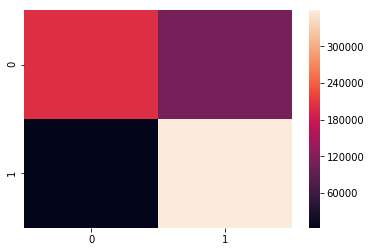

Learning Rate:[0.1]
epoch224
train loss: 6.2050571614236105e-06
valid loss: 6.204395504028071e-06
accuracy: 83.11437037037037 %


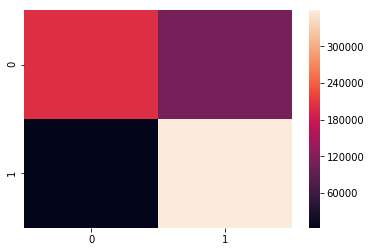

Learning Rate:[0.010000000000000002]
epoch225
train loss: 6.1842374634579755e-06
valid loss: 6.174596364871832e-06
accuracy: 83.2011851851852 %


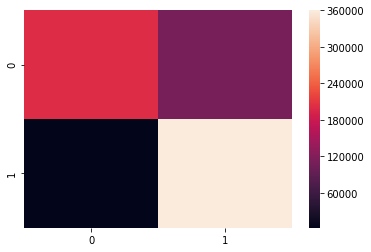

Learning Rate:[0.1]
epoch226
train loss: 6.166110324556939e-06
valid loss: 6.1493269640777726e-06
accuracy: 83.30103703703703 %


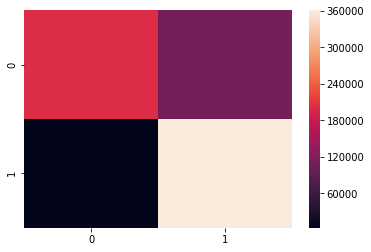

Learning Rate:[0.010000000000000002]
epoch227
train loss: 5.982786660752026e-06
valid loss: 5.861073987034615e-06
accuracy: 84.67733333333334 %


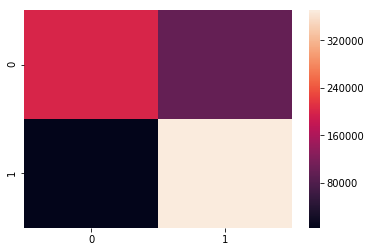

Learning Rate:[0.1]
epoch228
train loss: 5.850860361533705e-06
valid loss: 5.84761573918513e-06
accuracy: 84.75466666666667 %


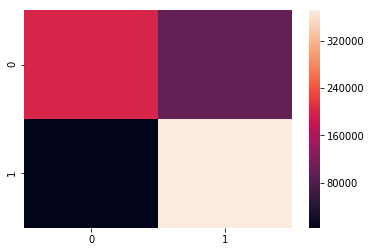

Learning Rate:[0.010000000000000002]
epoch229
train loss: 5.809058166050818e-06
valid loss: 5.772794338554377e-06
accuracy: 85.34725925925926 %


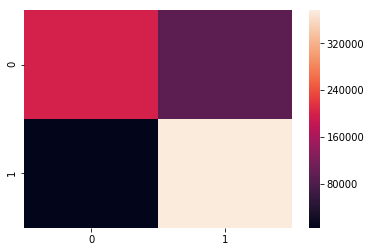

Learning Rate:[0.1]
epoch230
train loss: 5.770853022113442e-06
valid loss: 5.770014467998408e-06
accuracy: 85.38637037037037 %


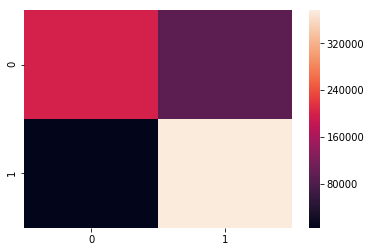

Learning Rate:[0.010000000000000002]
epoch231
train loss: 5.765458354289876e-06
valid loss: 5.749610409111483e-06
accuracy: 85.66444444444444 %


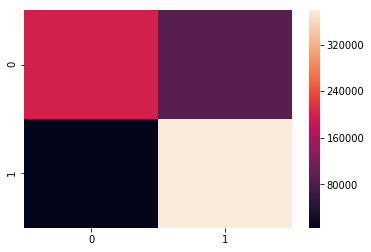

Learning Rate:[0.1]
epoch232
train loss: 5.749254341935739e-06
valid loss: 5.746375336457277e-06
accuracy: 85.69866666666667 %


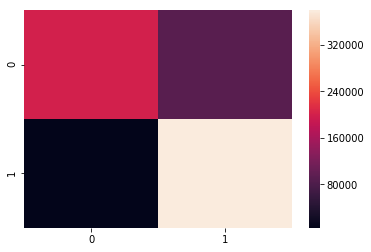

Learning Rate:[0.010000000000000002]
epoch233
train loss: 5.6909743761934806e-06
valid loss: 5.673462055710843e-06
accuracy: 86.64133333333334 %


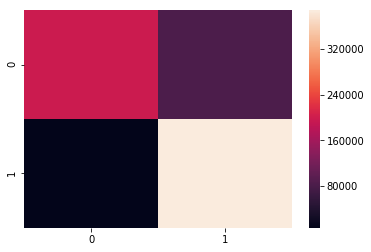

Learning Rate:[0.1]
epoch234
train loss: 5.672592124028597e-06
valid loss: 5.679115474777063e-06
accuracy: 86.69451851851852 %


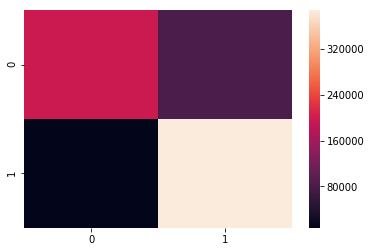

Learning Rate:[0.010000000000000002]
epoch235
train loss: 5.6615513130964246e-06
valid loss: 5.660915576299885e-06
accuracy: 87.17303703703703 %


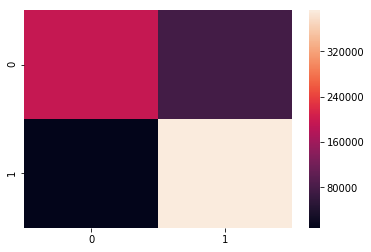

Learning Rate:[0.1]
epoch236
train loss: 5.660999704559799e-06
valid loss: 5.659103408106603e-06
accuracy: 87.20503703703703 %


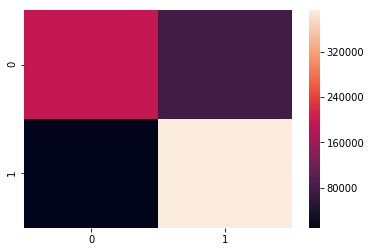

Learning Rate:[0.010000000000000002]
epoch237
train loss: 5.660644546878757e-06
valid loss: 5.92169635638129e-06
accuracy: 87.79185185185186 %
saved


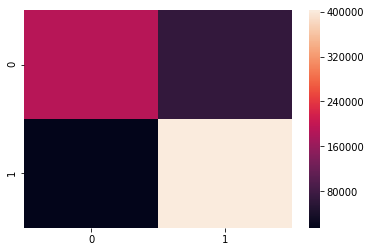

Learning Rate:[0.1]
epoch238
train loss: 5.930651695962297e-06
valid loss: 5.943032192590181e-06
accuracy: 87.84651851851852 %
saved


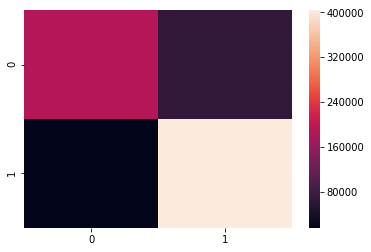

Learning Rate:[0.010000000000000002]
epoch239
train loss: 6.038443189027021e-06
valid loss: 6.132020644145086e-06
accuracy: 88.128 %
saved


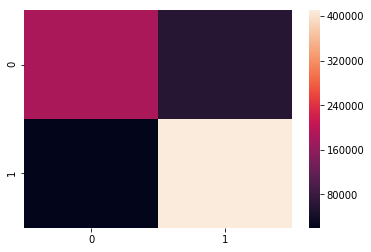

Learning Rate:[0.1]
epoch240
train loss: 6.1435953284672e-06
valid loss: 6.145381576061482e-06
accuracy: 88.14918518518519 %
saved


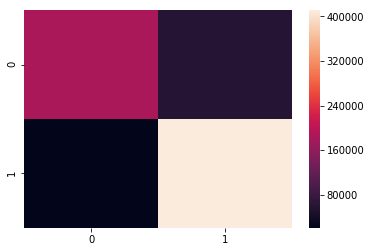

Learning Rate:[0.010000000000000002]
epoch241
train loss: 6.169793323351769e-06
valid loss: 5.898251401958987e-06
accuracy: 87.4768888888889 %


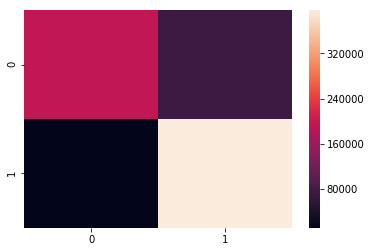

Learning Rate:[0.1]
epoch242
train loss: 5.91441721553565e-06
valid loss: 5.904327736061532e-06
accuracy: 87.42592592592592 %


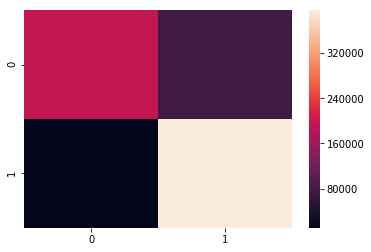

Learning Rate:[0.010000000000000002]
epoch243
train loss: 5.950537797616562e-06
valid loss: 5.896116817893926e-06
accuracy: 87.05155555555557 %


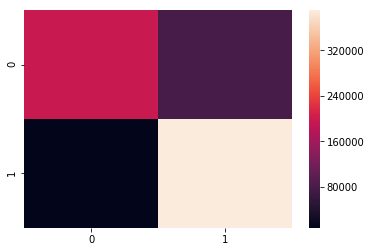

Learning Rate:[0.1]
epoch244
train loss: 5.893788511457387e-06
valid loss: 5.89166074860259e-06
accuracy: 87.01037037037037 %


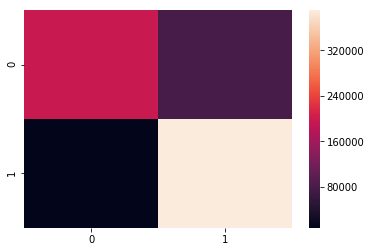

Learning Rate:[0.010000000000000002]
epoch245
train loss: 5.807037723570829e-06
valid loss: 5.765023161075078e-06
accuracy: 86.85199999999999 %


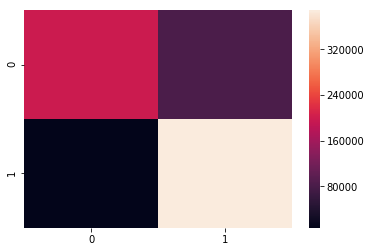

Learning Rate:[0.1]
epoch246
train loss: 5.756881819252158e-06
valid loss: 5.752303422923433e-06
accuracy: 86.84459259259259 %


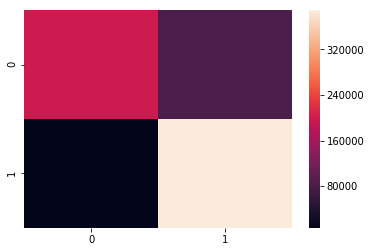

Learning Rate:[0.010000000000000002]
epoch247
train loss: 5.679373771272367e-06
valid loss: 5.6636185945535544e-06
accuracy: 86.80266666666667 %


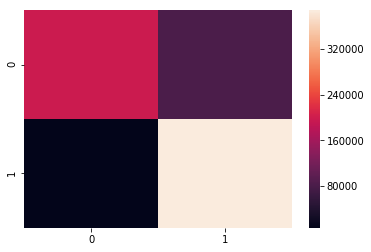

Learning Rate:[0.1]
epoch248
train loss: 5.6590120038890745e-06
valid loss: 5.658248937834287e-06
accuracy: 86.8 %


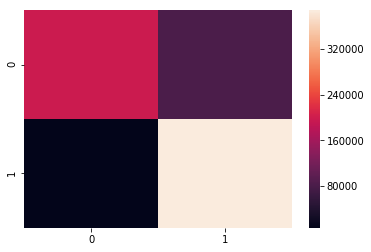

Learning Rate:[0.010000000000000002]
epoch249
train loss: 5.623887773253955e-06
valid loss: 5.623390279652085e-06
accuracy: 86.79807407407407 %


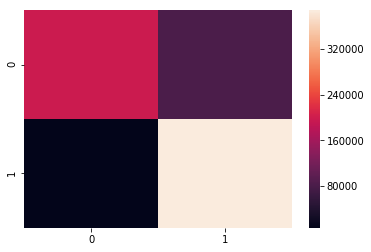

Learning Rate:[0.1]
epoch250
train loss: 5.621622221951839e-06
valid loss: 5.6215303629869595e-06
accuracy: 86.79807407407407 %


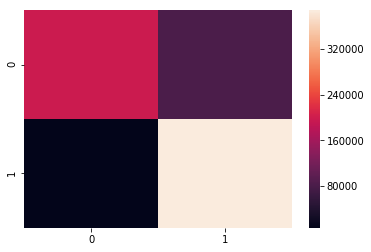

Learning Rate:[0.010000000000000002]
epoch251
train loss: 5.613418579741847e-06
valid loss: 5.613665052806027e-06
accuracy: 86.79466666666667 %


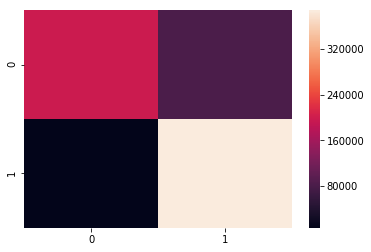

Learning Rate:[0.1]
epoch252
train loss: 5.613509074464673e-06
valid loss: 5.613385837932583e-06
accuracy: 86.79466666666667 %


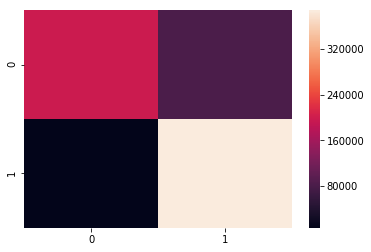

Learning Rate:[0.010000000000000002]
epoch253
train loss: 5.622958724416094e-06
valid loss: 5.4588226703344844e-06
accuracy: 87.30607407407408 %


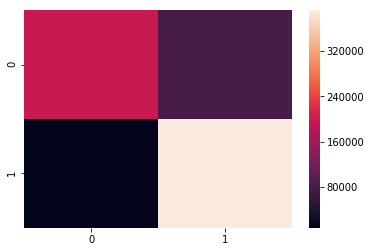

Learning Rate:[0.1]
epoch254
train loss: 5.424354640126694e-06
valid loss: 5.420821253210306e-06
accuracy: 87.43837037037036 %


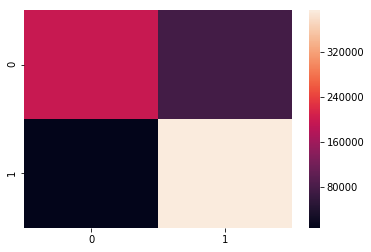

Learning Rate:[0.010000000000000002]
epoch255
train loss: 5.280369805404916e-06
valid loss: 5.289619821269298e-06
accuracy: 88.27881481481481 %
saved


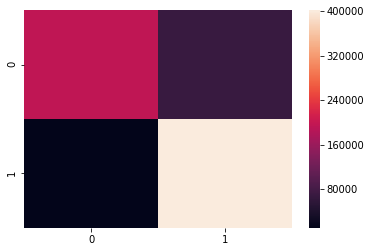

Learning Rate:[0.1]
epoch256
train loss: 5.286582108965376e-06
valid loss: 5.294072707329178e-06
accuracy: 88.31392592592593 %
saved


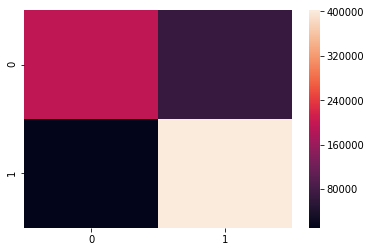

Learning Rate:[0.010000000000000002]
epoch257
train loss: 5.29897761225584e-06
valid loss: 5.3934913921693806e-06
accuracy: 88.50622222222222 %
saved


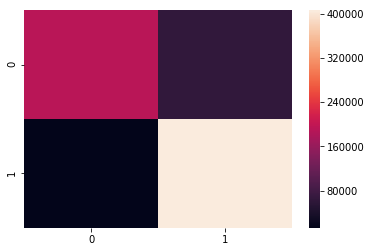

Learning Rate:[0.1]
epoch258
train loss: 5.399850579124177e-06
valid loss: 5.419949047791306e-06
accuracy: 88.49718518518519 %


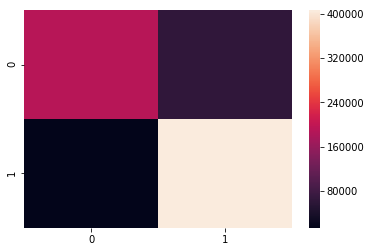

Learning Rate:[0.010000000000000002]
epoch259
train loss: 5.513546511792811e-06
valid loss: 5.7621250562078785e-06
accuracy: 88.28266666666667 %


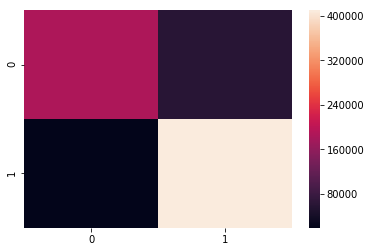

Learning Rate:[0.1]
epoch260
train loss: 5.746170700149378e-06
valid loss: 5.613123903458472e-06
accuracy: 88.27511111111112 %


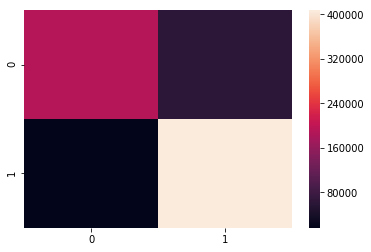

Learning Rate:[0.010000000000000002]
epoch261
train loss: 5.649201739288401e-06
valid loss: 5.5753494052623864e-06
accuracy: 87.22533333333334 %


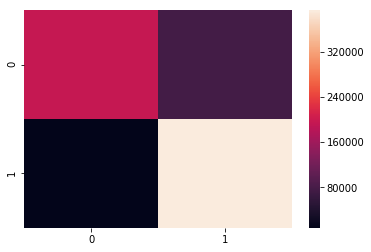

Learning Rate:[0.1]
epoch262
train loss: 5.5833679653005674e-06
valid loss: 5.588316525972914e-06
accuracy: 87.13392592592592 %


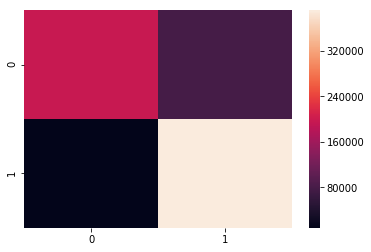

Learning Rate:[0.010000000000000002]
epoch263
train loss: 5.626053280138876e-06
valid loss: 5.623335255222628e-06
accuracy: 86.43362962962962 %


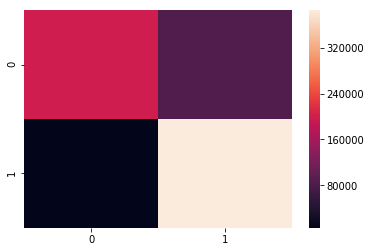

Learning Rate:[0.1]
epoch264
train loss: 5.620539013762027e-06
valid loss: 5.61507204110967e-06
accuracy: 86.39155555555556 %


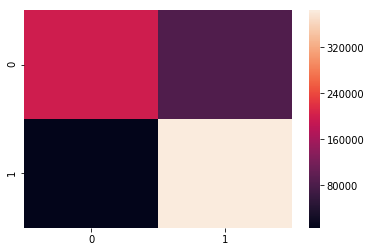

Learning Rate:[0.010000000000000002]
epoch265
train loss: 5.569102540903259e-06
valid loss: 5.540412075788481e-06
accuracy: 86.07096296296297 %


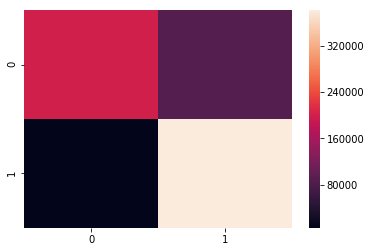

Learning Rate:[0.1]
epoch266
train loss: 5.535501713893609e-06
valid loss: 5.532233899430139e-06
accuracy: 86.05392592592592 %


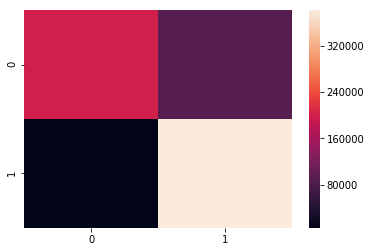

Learning Rate:[0.010000000000000002]
epoch267
train loss: 5.453817266243277e-06
valid loss: 5.417361080617411e-06
accuracy: 86.31748148148148 %


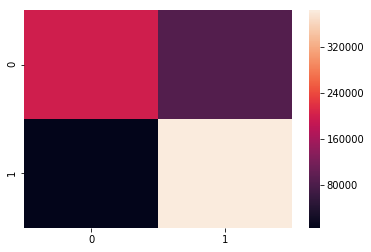

Learning Rate:[0.1]
epoch268
train loss: 5.412795871961862e-06
valid loss: 5.411128313426161e-06
accuracy: 86.33896296296297 %


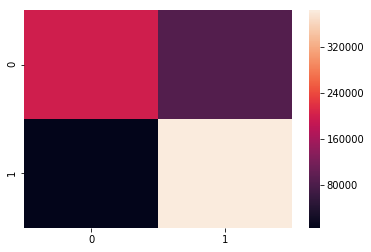

Learning Rate:[0.010000000000000002]
epoch269
train loss: 5.557430085900705e-06
valid loss: 5.718237389373826e-06
accuracy: 84.78162962962963 %


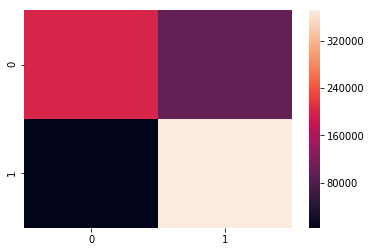

Learning Rate:[0.1]
epoch270
train loss: 5.736670573242009e-06
valid loss: 5.750380296376534e-06
accuracy: 84.67185185185186 %


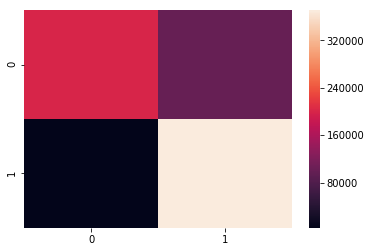

Learning Rate:[0.010000000000000002]
epoch271
train loss: 5.885916834813543e-06
valid loss: 5.995359970256686e-06
accuracy: 83.86503703703704 %


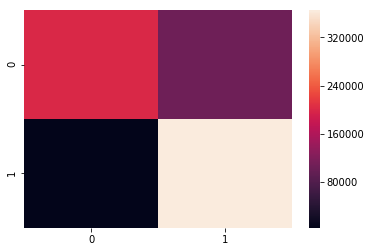

Learning Rate:[0.1]
epoch272
train loss: 6.003959242661949e-06
valid loss: 6.011506684444612e-06
accuracy: 83.80533333333334 %


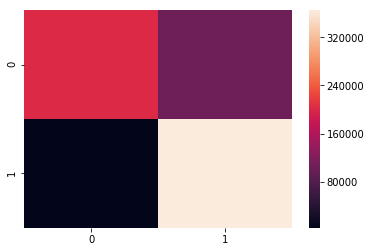

Learning Rate:[0.010000000000000002]
epoch273
train loss: 6.062644843041198e-06
valid loss: 6.07976426181267e-06
accuracy: 83.43496296296297 %


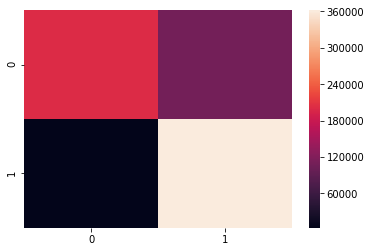

Learning Rate:[0.1]
epoch274
train loss: 6.081079391151434e-06
valid loss: 6.082717845856678e-06
accuracy: 83.40888888888888 %


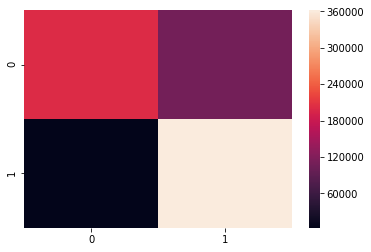

Learning Rate:[0.010000000000000002]
epoch275
train loss: 6.106140062911436e-06
valid loss: 6.122453669377137e-06
accuracy: 83.22562962962962 %


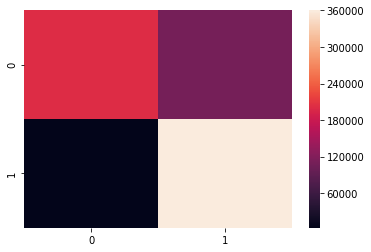

Learning Rate:[0.1]
epoch276
train loss: 6.12526127952151e-06
valid loss: 6.125557320046937e-06
accuracy: 83.21274074074074 %


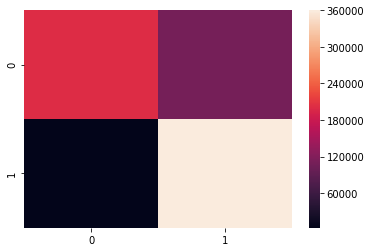

Learning Rate:[0.010000000000000002]
epoch277
train loss: 6.141399353509769e-06
valid loss: 6.138453954918077e-06
accuracy: 83.14859259259259 %


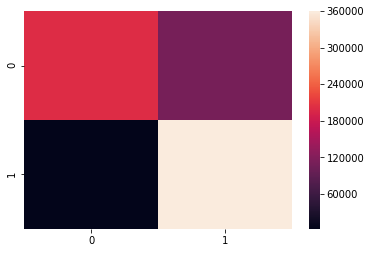

Learning Rate:[0.1]
epoch278
train loss: 6.139372089819517e-06
valid loss: 6.1382847889035475e-06
accuracy: 83.1474074074074 %


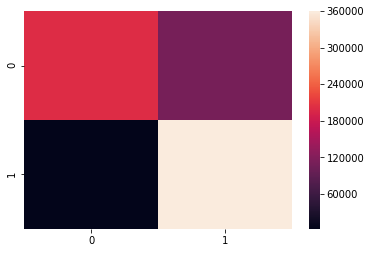

Learning Rate:[0.010000000000000002]
epoch279
train loss: 6.09402013651561e-06
valid loss: 6.02420732320752e-06
accuracy: 83.49718518518519 %


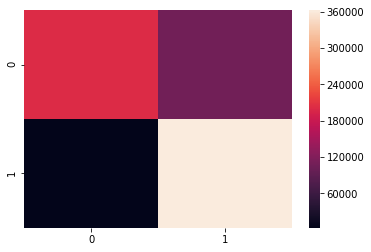

Learning Rate:[0.1]
epoch280
train loss: 6.0162183217471465e-06
valid loss: 6.013592610543128e-06
accuracy: 83.53851851851853 %


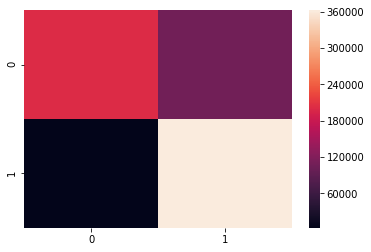

Learning Rate:[0.010000000000000002]
epoch281
train loss: 5.9587905525404494e-06
valid loss: 5.924470315221697e-06
accuracy: 83.84814814814816 %


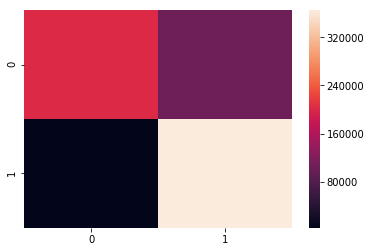

Learning Rate:[0.1]
epoch282
train loss: 5.922107902733842e-06
valid loss: 5.918706392549211e-06
accuracy: 83.87022222222222 %


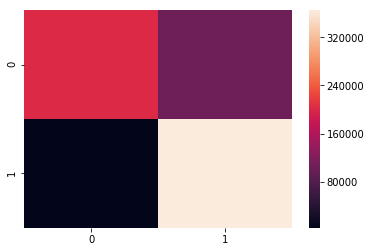

Learning Rate:[0.010000000000000002]
epoch283
train loss: 5.8932191677740775e-06
valid loss: 5.873339432582725e-06
accuracy: 84.03511111111112 %


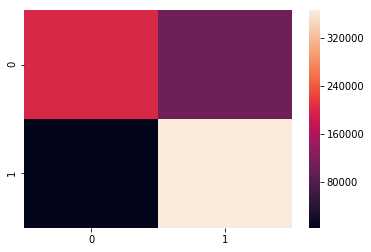

Learning Rate:[0.1]
epoch284
train loss: 5.871658231626498e-06
valid loss: 5.870173026778502e-06
accuracy: 84.04814814814814 %


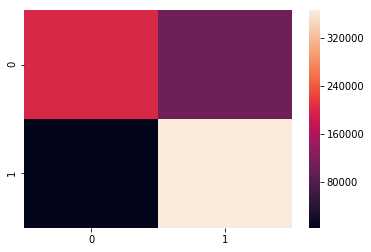

Learning Rate:[0.010000000000000002]
epoch285
train loss: 5.854460141563322e-06
valid loss: 5.843834514962509e-06
accuracy: 84.13896296296296 %


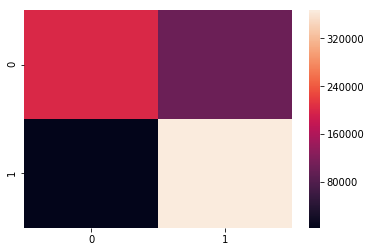

Learning Rate:[0.1]
epoch286
train loss: 5.843182407261338e-06
valid loss: 5.842578957526712e-06
accuracy: 84.14533333333334 %


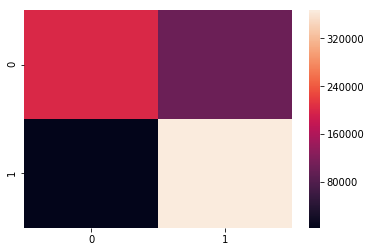

Learning Rate:[0.010000000000000002]
epoch287
train loss: 5.968868208583444e-06
valid loss: 6.028151801729109e-06
accuracy: 83.45866666666667 %


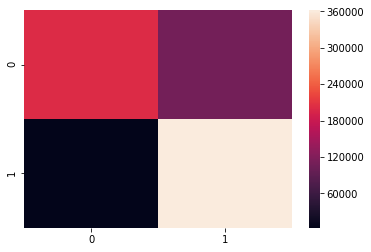

Learning Rate:[0.1]
epoch288
train loss: 6.032635155861499e-06
valid loss: 6.036263130226871e-06
accuracy: 83.42103703703704 %


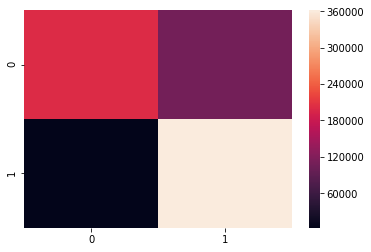

Learning Rate:[0.010000000000000002]
epoch289
train loss: 6.0851539274153765e-06
valid loss: 6.108053185016615e-06
accuracy: 83.14474074074074 %


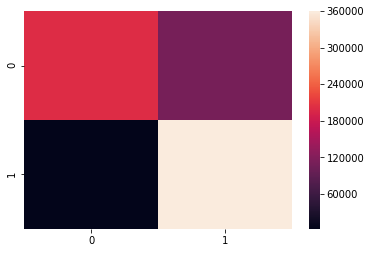

Learning Rate:[0.1]
epoch290
train loss: 6.094015589042101e-06
valid loss: 6.0824063439213205e-06
accuracy: 83.22162962962963 %


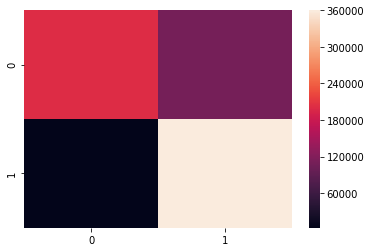

Learning Rate:[0.010000000000000002]
epoch291
train loss: 5.950053946435219e-06
valid loss: 5.914608664170373e-06
accuracy: 83.77866666666667 %


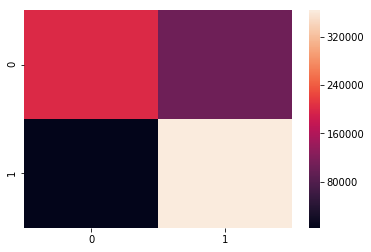

Learning Rate:[0.1]
epoch292
train loss: 5.907720606046496e-06
valid loss: 5.905204943701392e-06
accuracy: 83.80888888888889 %


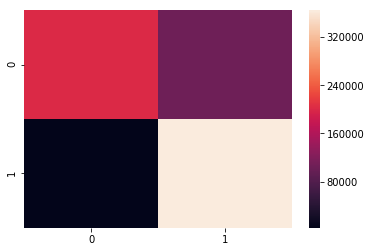

Learning Rate:[0.010000000000000002]
epoch293
train loss: 5.870354470971506e-06
valid loss: 5.8460568652662914e-06
accuracy: 84.02311111111112 %


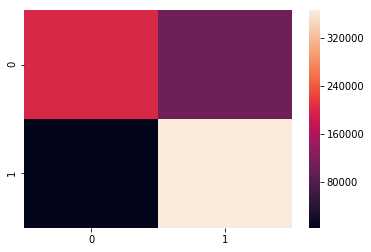

Learning Rate:[0.1]
epoch294
train loss: 5.844580300617963e-06
valid loss: 5.843015060236212e-06
accuracy: 84.036 %


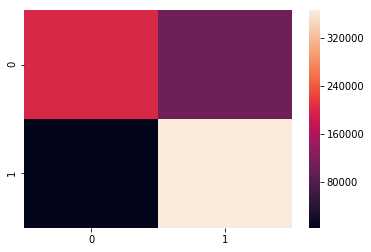

Learning Rate:[0.010000000000000002]
epoch295
train loss: 5.833172963320976e-06
valid loss: 5.839180630573537e-06
accuracy: 84.10177777777777 %


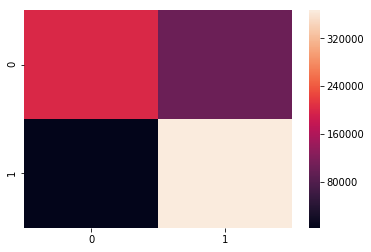

Learning Rate:[0.1]
epoch296
train loss: 5.843010512762703e-06
valid loss: 5.842853624926647e-06
accuracy: 84.08948148148147 %


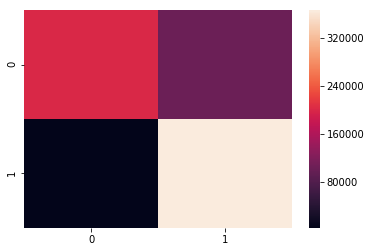

Learning Rate:[0.010000000000000002]
epoch297
train loss: 5.874324415344745e-06
valid loss: 5.8730443015519995e-06
accuracy: 83.9768888888889 %


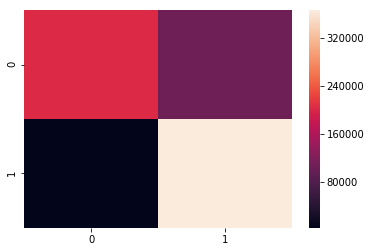

Learning Rate:[0.1]
epoch298
train loss: 5.874981070519425e-06
valid loss: 5.874818270967808e-06
accuracy: 83.96948148148148 %


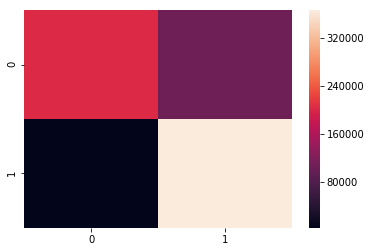

Learning Rate:[0.010000000000000002]
epoch299
train loss: 5.885824521101313e-06
valid loss: 5.885429345653392e-06
accuracy: 83.91481481481482 %


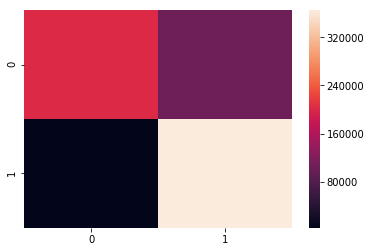

Learning Rate:[0.1]


In [28]:
# Training Loop 
%matplotlib inline
highest = 0
regular = 0
for k in range(300):
    
    running_loss= 0 
    corrects = 0
    #Train
    for inp, target in Train:
        optimizer.zero_grad()
        inp = inp.cuda()
        output = model.forward(inp.float())
        #train
        Thresholded = torch.gt(output.float(),torch.tensor([0.5]).float().cuda()).float()
        loss = nn.functional.binary_cross_entropy(output, target.float().cuda()) #+ regular*torch.nn.functional.mse_loss(Conv(Thresholded.reshape([1,1,output.shape[0]])),torch.zeros([1,1,output.shape[0]-1]).cuda()) 
        #loss = CrossEntropy(output, target.float().reshape(output.shape).cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss/len(target)  
    if k % 1==0: 
        print("epoch{}".format(k))
        print("train loss: {}".format(running_loss))
        #print("regular: {}".format(regular*torch.nn.functional.mse_loss(Conv(output.reshape([1,1,output.shape[0]])),torch.zeros([1,1,output.shape[0]-1]).cuda())/len(target)))
    running_loss= 0 
    # Added the option of just running the Training step for the first few epochs.
    if k > -1:
        # Validate. 
        a = np.array([])
        b= np.array([])
        for inp, target in Valid:
            inp = inp.cuda()
            output = model.forward(inp.float())
            Thresholded = torch.gt(output,torch.tensor([0.5]).float().cuda()).float()
            #valid
            loss = nn.functional.binary_cross_entropy(output, target.float().reshape(output.shape).cuda()) #+ regular*torch.nn.functional.mse_loss(Conv(Thresholded.reshape([1,1,output.shape[0]])),torch.zeros([1,1,output.shape[0]-1]).cuda())
            #Track Epoch Loss
            running_loss += loss/len(target)
            a = np.append(a,(output>0.5).cpu().numpy()) 
            b = np.append(b,(target.reshape(output.shape)>0.5).numpy())
        
        #Print out. 
        if k % 1 ==0: 
            print("valid loss: {}".format(running_loss))
            print("accuracy: {} %".format((a==b).mean().item()*100))
            if ((a==b).mean().item()*100)> highest:
                highest = ((a==b).mean().item()*100)
                #Save out model that achieves best accuracy. 
                torch.save(model.state_dict(), './ModelSave3.pt')
                print("saved")
            plt.figure()    
            sns.heatmap(confusion_matrix(a,b))
            plt.show()
            
    print("Learning Rate:{}".format(scheduler.get_lr()))
    scheduler.step() 

None


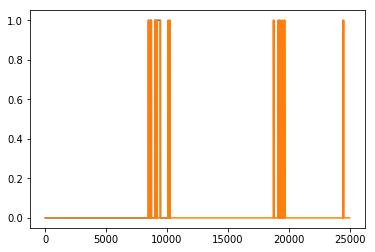

In [264]:
print(loss.grad)
plt.figure()
plt.plot(Thresholded.detach().cpu().numpy()[:10000])
plt.plot(Conv(Thresholded.reshape([1,1,output.shape[0]])).cpu().detach().numpy().flatten()**2)

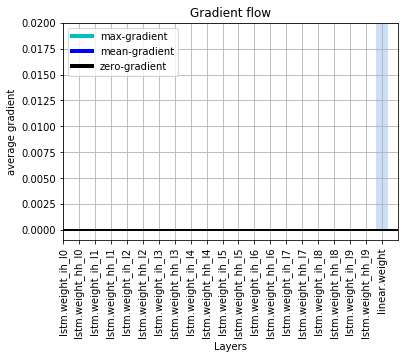

In [12]:
from matplotlib.lines import Line2D   
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
plot_grad_flow(model.named_parameters())

In [23]:
named_parameters = model.named_parameters()
ave_grads = []
layers = []
for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())

AttributeError: 'NoneType' object has no attribute 'abs'

In [24]:
type(p)
n

'layer2.weight'

model.named_parameters


# Evaluate Model
 Load up the best performing model. Run the model and Plot the results. 

In [22]:
model2 = Classifier(6, 6, batch_size=BatchSize, output_dim=1, num_layers=10)
model2.load_state_dict(torch.load('./ModelSave3.pt'))
model2.cuda()

df = pd.read_pickle("Reduced.pkl")
df3 = pd.read_pickle("Reduced3.pkl")
df = df.append(df3)
df = df.append(df4.drop('time',axis=1),sort=True)
#Load into Torch Dataset. 
Input = torch.tensor(InpScaler.transform(df[LabelList].values))
Output = torch.tensor(df['Labels'].values)

MainDataSet = torch.utils.data.TensorDataset(Input, Output)
Main = torch.utils.data.DataLoader(MainDataSet,batch_size = 200000,num_workers = 1)
full_results = torch.Tensor()
#Run Model over the batches. 
for inp, Label in Main:
    inp = inp.cuda()
    output = model2.forward(inp.float())

    full_results = torch.cat((full_results,output.cpu()),0)

In [239]:
#Confusion Plot. 
plt.figure()

full_results[:,-2] = full_results[:,-2]>0.5
sns.heatmap(confusion_matrix(full_results[:,-2].detach().numpy(),full_results[:,-1].detach().numpy()))
plt.show()

IndexError: too many indices for tensor of dimension 1

<Figure size 432x288 with 0 Axes>

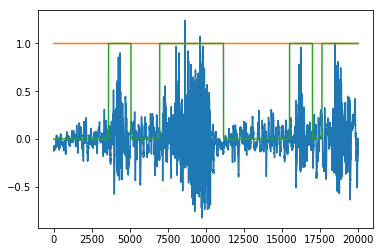

In [23]:
#Time Series
%matplotlib inline
plt.figure()
#plt.plot(full_results[:,-1].detach().numpy())
#plt.plot(full_results[:,-2].detach().numpy())

plt.plot(df['ts'].values[:20000])
plt.plot(full_results.detach().numpy()[:20000]>0.5)
plt.plot(df['Labels'].values[:20000])

plt.show()

In [112]:
full_results.shape


torch.Size([843750])

In [113]:
df

,ts,Labels,0,1,2,3,4,5
0,-0.100506,0,-0.017518,0.001688,0.000334,0.000028,-0.000025,0.000065
16,-0.112558,0,-0.017520,0.001688,0.000334,0.000028,-0.000025,0.000065
32,-0.122963,0,-0.017525,0.001688,0.000334,0.000028,-0.000025,0.000065
48,-0.124815,0,-0.017534,0.001687,0.000334,0.000028,-0.000025,0.000065
64,-0.114058,0,-0.017546,0.001687,0.000334,0.000028,-0.000025,0.000065
80,-0.106800,0,-0.017562,0.001687,0.000334,0.000028,-0.000025,0.000065
96,-0.111124,0,-0.017581,0.001686,0.000334,0.000028,-0.000025,0.000065
112,-0.109121,0,-0.017603,0.001686,0.000334,0.000028,-0.000025,0.000065
128,-0.103176,0,-0.017627,0.001685,0.000334,0.000028,-0.000025,0.000065
144,-0.101728,0,-0.017655,0.001684,0.000334,0.000028,-0.000025,0.000065
